In [1]:
import numpy as np
import pandas as pd
from math import *
import sys
from sys import stdout as cout
from CFLib.timer import Timer
from CFLib.stats import stats
from CFLib.euro_opt import impVolFromFwPut
from CFLib.euro_opt import impVolFromFwCall
from scipy.stats import norm
from scipy.stats import ncx2
import matplotlib.pyplot as plt

In [2]:
S_0 = 1
r = 0
q = 0
t = [1/12,2/12,3/12,6/12,1.0,1.5]
Strikes = [0.8,0.9,0.95,0.975,1.0,1.025,1.1,1.2]
sigma = [0.2, 0.35, 0.45, 0.6]
beta = [0.55,0.7,0.8,0.9]
eps = 0.009
Yrs = 1.5 # length of the trajectory in years
Nt = int(360*Yrs) # number of steps in the S trajectory
dt = Yrs/Nt # lenght of the time interval
NS = 100000 # number of S trajectories

In [3]:
Rand = np.random.default_rng(1234)
normal = Rand.normal(loc=0.0, scale=1.0, size=(NS, Nt+1))

In [4]:
def S_t_met1(S_0, NS, Nt, sigma, beta, dt, eps, normal):

    S_t = np.zeros((NS, Nt+1))
    S_t[:, 0] = S_0

    for i in range(1, Nt+1):
        for j in range(NS):
            if S_t[j, i-1] < eps:
                S_t[j, i] = S_t[j, i-1] + sigma * S_t[j, i-1] * eps**(beta-1) * np.sqrt(dt) * normal[j, i-1]
            else:
                S_t[j, i] = S_t[j, i-1] + sigma * (S_t[j, i-1]**(beta)) * np.sqrt(dt) * normal[j, i-1]

    return S_t

In [5]:
def S_t_met2(S_0, NS, Nt, sigma, beta, dt, eps, normal):

    S_t = np.zeros((NS, Nt+1))
    S_t[:, 0] = S_0

    for i in range(1, Nt+1):
        for j in range(NS):
            if S_t[j, i-1] < eps:
                S_t[j, i] = S_t[j, i-1] * exp(-0.5 * sigma * sigma * (eps**(2*(beta-1))) * dt + sqrt(dt) * sigma *(eps**(beta-1)) * normal[j, i-1])
            else:
                S_t[j, i] = S_t[j, i-1] * exp(-0.5 * sigma**2 * S_t[j, i-1]**(2*(beta-1)) * dt + sqrt(dt) * sigma * S_t[j, i-1]**(beta-1) * normal[j, i-1])
    return S_t


In [6]:
def martingale_property(S_t_des, S_0, NS, s, b, method):
    
    T1 = Timer()

    cout.write("%9s    %8s   %8s    %8s    %12s\n" %("t", "E[S(t)]", "|S(0)-E[S(t)]|", "MC-err", "elapsed"))
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axhline(y=1, color='red', linestyle='-', linewidth=1)
    E_values = [] 

    S_t = S_t_des
        
    for i in [0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510,540]:
        T1.start()
    
        E,std = stats(S_t[:, i])
        Err = 1.65 * std / sqrt(NS)
            
        t1 = T1.stop()
        cout.write("%9s    %8.6f      %8.2e        %8.2e    %8.4f sec.\n" %(i, E, abs(1 - E), Err, t1))

        ax.errorbar(i, E, yerr=Err, fmt='x', color='black', markersize=5)  
        E_values.append(E)  

    ax.plot([0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510,540], E_values, marker='x', color='black', linestyle='-', linewidth=0.5)
        
    ax.set_xlabel('t (Days)')
    ax.set_ylabel('E[S(t)]')
    ax.set_title('Martingality test with Method {}, sigma = {} and beta = {} (NS = {})'.format(method,s,b,NS))
    ax.grid(False)
    plt.show()

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0063 sec.
       30    1.000189      1.89e-04        3.02e-04      0.0044 sec.
       60    1.000194      1.94e-04        4.27e-04      0.0044 sec.
       90    1.000312      3.12e-04        5.24e-04      0.0042 sec.
      120    1.000086      8.59e-05        6.06e-04      0.0052 sec.
      150    0.999688      3.12e-04        6.78e-04      0.0047 sec.
      180    0.999629      3.71e-04        7.43e-04      0.0050 sec.
      210    0.999634      3.66e-04        8.01e-04      0.0043 sec.
      240    0.999400      6.00e-04        8.54e-04      0.0045 sec.
      270    0.999428      5.72e-04        9.05e-04      0.0043 sec.
      300    0.999525      4.75e-04        9.54e-04      0.0041 sec.
      330    0.999573      4.27e-04        1.00e-03      0.0042 sec.
      360    0.999636      3.64e-04        1.04e-03      0.0043 sec.
      390    0.999641      3.59e-04 

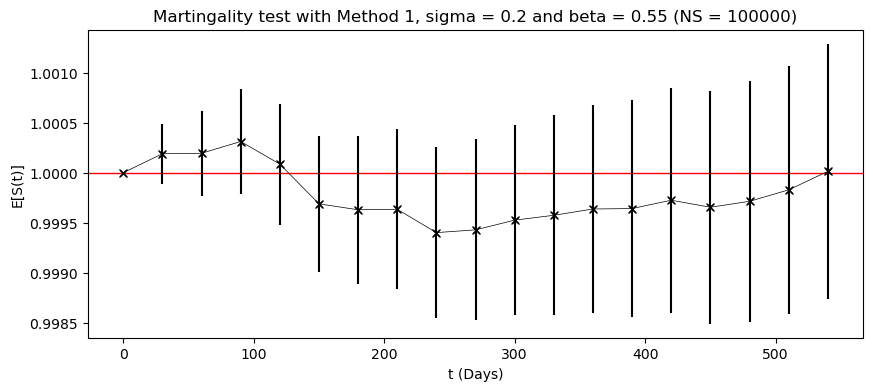

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0043 sec.
       30    1.000190      1.90e-04        3.02e-04      0.0052 sec.
       60    1.000197      1.97e-04        4.27e-04      0.0045 sec.
       90    1.000317      3.17e-04        5.24e-04      0.0048 sec.
      120    1.000091      9.10e-05        6.06e-04      0.0043 sec.
      150    0.999694      3.06e-04        6.78e-04      0.0047 sec.
      180    0.999637      3.63e-04        7.43e-04      0.0047 sec.
      210    0.999642      3.58e-04        8.01e-04      0.0045 sec.
      240    0.999410      5.90e-04        8.54e-04      0.0049 sec.
      270    0.999436      5.64e-04        9.05e-04      0.0048 sec.
      300    0.999533      4.67e-04        9.54e-04      0.0050 sec.
      330    0.999583      4.17e-04        1.00e-03      0.0049 sec.
      360    0.999647      3.53e-04        1.04e-03      0.0050 sec.
      390    0.999651      3.49e-04 

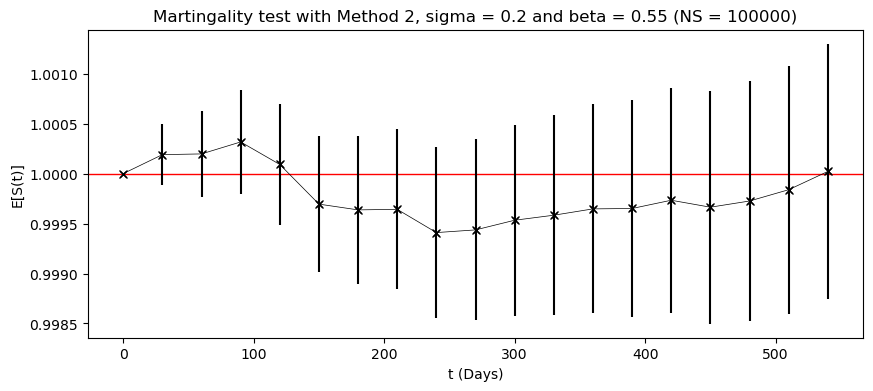

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0086 sec.
       30    1.000190      1.90e-04        3.02e-04      0.0077 sec.
       60    1.000197      1.97e-04        4.27e-04      0.0065 sec.
       90    1.000317      3.17e-04        5.24e-04      0.0058 sec.
      120    1.000095      9.53e-05        6.06e-04      0.0080 sec.
      150    0.999703      2.97e-04        6.79e-04      0.0090 sec.
      180    0.999648      3.52e-04        7.44e-04      0.0062 sec.
      210    0.999651      3.49e-04        8.02e-04      0.0065 sec.
      240    0.999409      5.91e-04        8.56e-04      0.0096 sec.
      270    0.999432      5.68e-04        9.07e-04      0.0068 sec.
      300    0.999532      4.68e-04        9.56e-04      0.0070 sec.
      330    0.999582      4.18e-04        1.00e-03      0.0057 sec.
      360    0.999640      3.60e-04        1.05e-03      0.0080 sec.
      390    0.999641      3.59e-04 

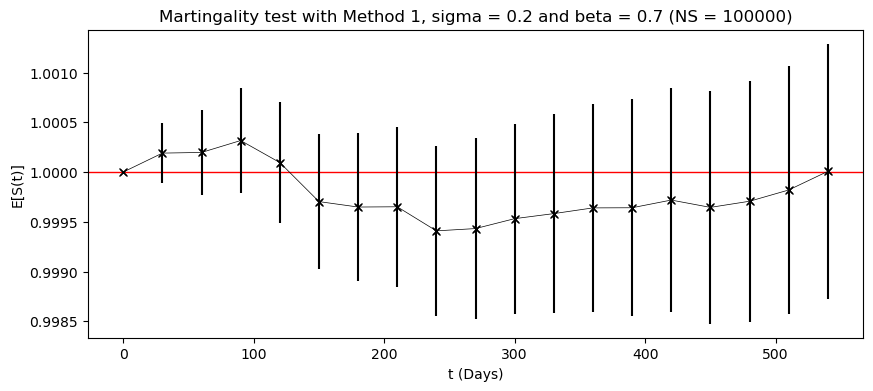

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0046 sec.
       30    1.000190      1.90e-04        3.02e-04      0.0046 sec.
       60    1.000199      1.99e-04        4.27e-04      0.0043 sec.
       90    1.000321      3.21e-04        5.24e-04      0.0042 sec.
      120    1.000101      1.01e-04        6.06e-04      0.0046 sec.
      150    0.999709      2.91e-04        6.79e-04      0.0043 sec.
      180    0.999656      3.44e-04        7.44e-04      0.0045 sec.
      210    0.999659      3.41e-04        8.02e-04      0.0054 sec.
      240    0.999418      5.82e-04        8.56e-04      0.0055 sec.
      270    0.999441      5.59e-04        9.07e-04      0.0053 sec.
      300    0.999540      4.60e-04        9.56e-04      0.0056 sec.
      330    0.999592      4.08e-04        1.00e-03      0.0070 sec.
      360    0.999650      3.50e-04        1.05e-03      0.0056 sec.
      390    0.999651      3.49e-04 

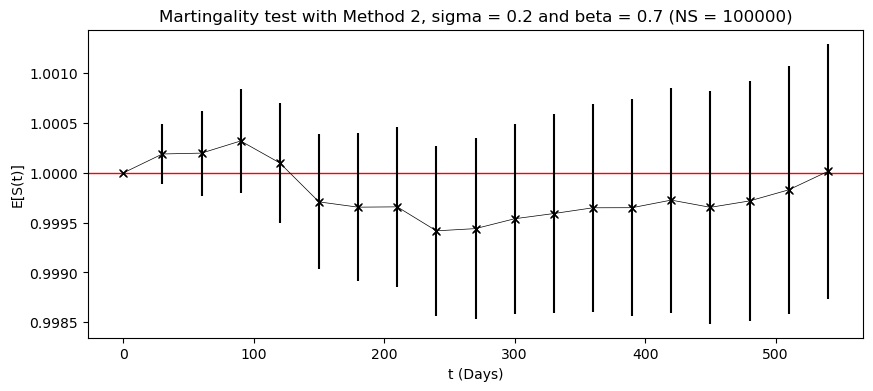

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0103 sec.
       30    1.000191      1.91e-04        3.02e-04      0.0067 sec.
       60    1.000198      1.98e-04        4.28e-04      0.0317 sec.
       90    1.000320      3.20e-04        5.24e-04      0.0071 sec.
      120    1.000102      1.02e-04        6.07e-04      0.0049 sec.
      150    0.999713      2.87e-04        6.79e-04      0.0057 sec.
      180    0.999661      3.39e-04        7.45e-04      0.0068 sec.
      210    0.999662      3.38e-04        8.03e-04      0.0091 sec.
      240    0.999415      5.85e-04        8.57e-04      0.0105 sec.
      270    0.999435      5.65e-04        9.08e-04      0.0072 sec.
      300    0.999536      4.64e-04        9.58e-04      0.0060 sec.
      330    0.999588      4.12e-04        1.01e-03      0.0063 sec.
      360    0.999641      3.59e-04        1.05e-03      0.0081 sec.
      390    0.999641      3.59e-04 

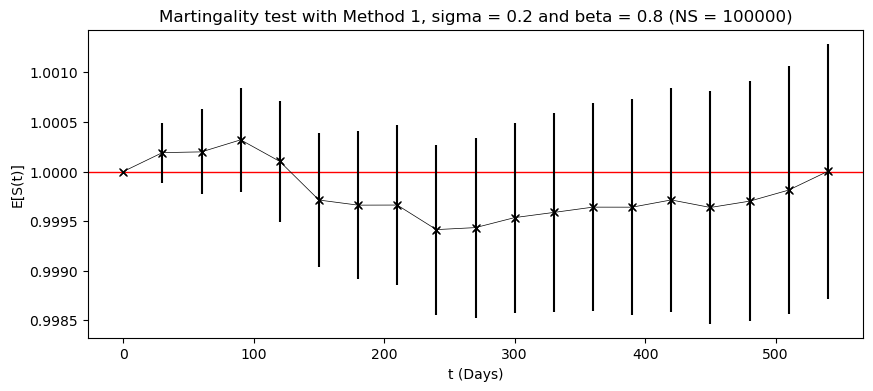

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0039 sec.
       30    1.000191      1.91e-04        3.02e-04      0.0051 sec.
       60    1.000201      2.01e-04        4.28e-04      0.0050 sec.
       90    1.000324      3.24e-04        5.24e-04      0.0048 sec.
      120    1.000107      1.07e-04        6.07e-04      0.0044 sec.
      150    0.999719      2.81e-04        6.79e-04      0.0047 sec.
      180    0.999669      3.31e-04        7.45e-04      0.0045 sec.
      210    0.999671      3.29e-04        8.03e-04      0.0050 sec.
      240    0.999424      5.76e-04        8.57e-04      0.0044 sec.
      270    0.999444      5.56e-04        9.08e-04      0.0047 sec.
      300    0.999544      4.56e-04        9.58e-04      0.0040 sec.
      330    0.999598      4.02e-04        1.01e-03      0.0050 sec.
      360    0.999652      3.48e-04        1.05e-03      0.0046 sec.
      390    0.999651      3.49e-04 

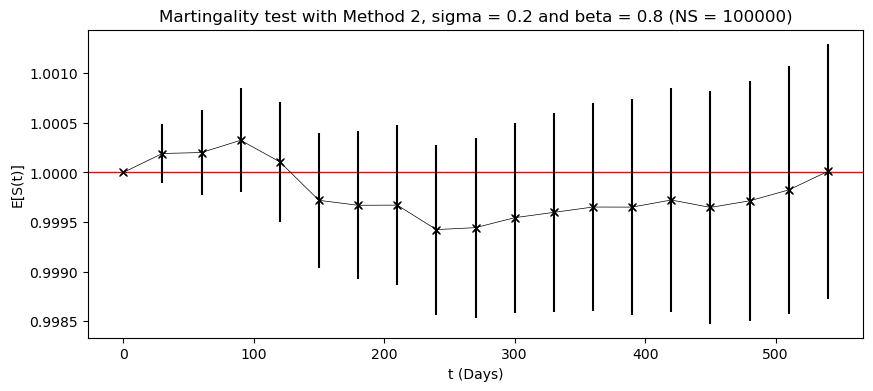

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0057 sec.
       30    1.000191      1.91e-04        3.02e-04      0.0053 sec.
       60    1.000200      2.00e-04        4.28e-04      0.0054 sec.
       90    1.000323      3.23e-04        5.25e-04      0.0051 sec.
      120    1.000108      1.08e-04        6.07e-04      0.0054 sec.
      150    0.999723      2.77e-04        6.80e-04      0.0054 sec.
      180    0.999675      3.25e-04        7.46e-04      0.0055 sec.
      210    0.999674      3.26e-04        8.05e-04      0.0052 sec.
      240    0.999421      5.79e-04        8.58e-04      0.0053 sec.
      270    0.999438      5.62e-04        9.10e-04      0.0051 sec.
      300    0.999540      4.60e-04        9.60e-04      0.0052 sec.
      330    0.999593      4.07e-04        1.01e-03      0.0053 sec.
      360    0.999642      3.58e-04        1.05e-03      0.0052 sec.
      390    0.999641      3.59e-04 

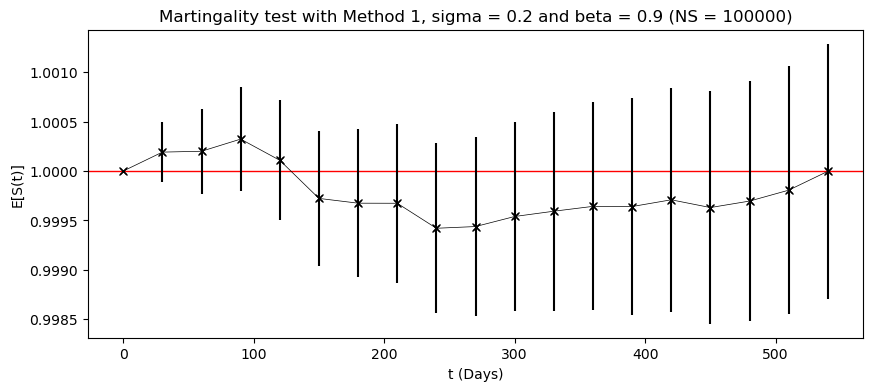

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0057 sec.
       30    1.000191      1.91e-04        3.02e-04      0.0041 sec.
       60    1.000203      2.03e-04        4.28e-04      0.0042 sec.
       90    1.000328      3.28e-04        5.25e-04      0.0040 sec.
      120    1.000114      1.14e-04        6.07e-04      0.0043 sec.
      150    0.999729      2.71e-04        6.80e-04      0.0039 sec.
      180    0.999683      3.17e-04        7.46e-04      0.0042 sec.
      210    0.999682      3.18e-04        8.05e-04      0.0042 sec.
      240    0.999430      5.70e-04        8.58e-04      0.0041 sec.
      270    0.999447      5.53e-04        9.10e-04      0.0044 sec.
      300    0.999548      4.52e-04        9.60e-04      0.0043 sec.
      330    0.999603      3.97e-04        1.01e-03      0.0048 sec.
      360    0.999653      3.47e-04        1.05e-03      0.0043 sec.
      390    0.999651      3.49e-04 

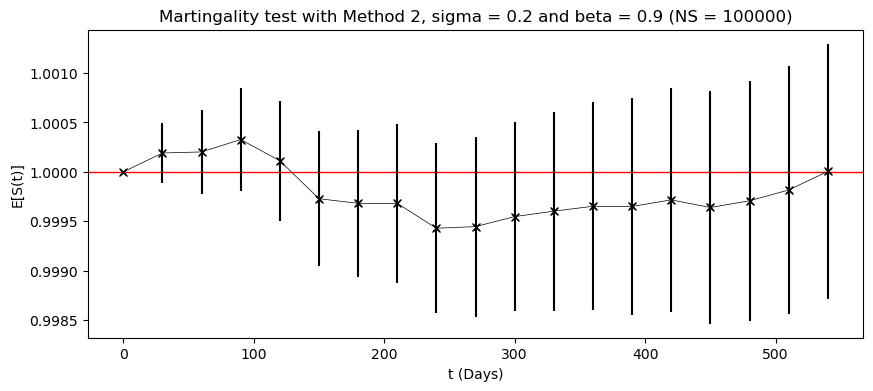

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0058 sec.
       30    1.000335      3.35e-04        5.28e-04      0.0047 sec.
       60    1.000350      3.50e-04        7.48e-04      0.0057 sec.
       90    1.000566      5.66e-04        9.17e-04      0.0056 sec.
      120    1.000194      1.94e-04        1.06e-03      0.0056 sec.
      150    0.999530      4.70e-04        1.19e-03      0.0058 sec.
      180    0.999446      5.54e-04        1.30e-03      0.0056 sec.
      210    0.999445      5.55e-04        1.40e-03      0.0057 sec.
      240    0.998995      1.01e-03        1.50e-03      0.0057 sec.
      270    0.999018      9.82e-04        1.59e-03      0.0054 sec.
      300    0.999206      7.94e-04        1.67e-03      0.0048 sec.
      330    0.999302      6.98e-04        1.75e-03      0.0050 sec.
      360    0.999390      6.10e-04        1.83e-03      0.0052 sec.
      390    0.999376      6.24e-04 

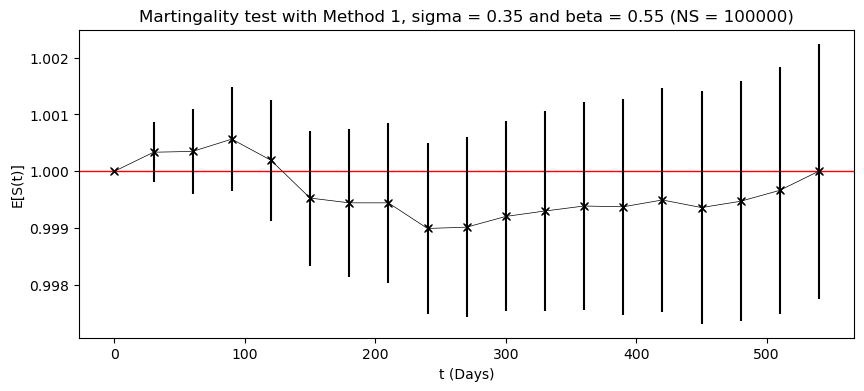

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0043 sec.
       30    1.000336      3.36e-04        5.28e-04      0.0040 sec.
       60    1.000358      3.58e-04        7.48e-04      0.0040 sec.
       90    1.000580      5.80e-04        9.17e-04      0.0042 sec.
      120    1.000210      2.10e-04        1.06e-03      0.0043 sec.
      150    0.999549      4.51e-04        1.19e-03      0.0039 sec.
      180    0.999470      5.30e-04        1.30e-03      0.0044 sec.
      210    0.999471      5.29e-04        1.40e-03      0.0042 sec.
      240    0.999024      9.76e-04        1.50e-03      0.0042 sec.
      270    0.999045      9.55e-04        1.59e-03      0.0039 sec.
      300    0.999232      7.68e-04        1.67e-03      0.0047 sec.
      330    0.999332      6.68e-04        1.75e-03      0.0041 sec.
      360    0.999421      5.79e-04        1.83e-03      0.0044 sec.
      390    0.999406      5.94e-04 

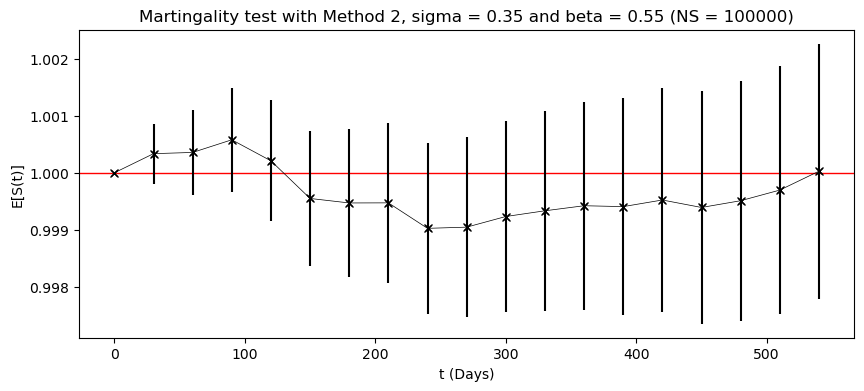

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0042 sec.
       30    1.000337      3.37e-04        5.29e-04      0.0043 sec.
       60    1.000358      3.58e-04        7.49e-04      0.0042 sec.
       90    1.000581      5.81e-04        9.19e-04      0.0046 sec.
      120    1.000224      2.24e-04        1.06e-03      0.0044 sec.
      150    0.999575      4.25e-04        1.19e-03      0.0043 sec.
      180    0.999507      4.93e-04        1.31e-03      0.0043 sec.
      210    0.999498      5.02e-04        1.41e-03      0.0042 sec.
      240    0.999024      9.76e-04        1.50e-03      0.0041 sec.
      270    0.999035      9.65e-04        1.59e-03      0.0042 sec.
      300    0.999227      7.73e-04        1.68e-03      0.0043 sec.
      330    0.999328      6.72e-04        1.76e-03      0.0040 sec.
      360    0.999395      6.05e-04        1.84e-03      0.0042 sec.
      390    0.999376      6.24e-04 

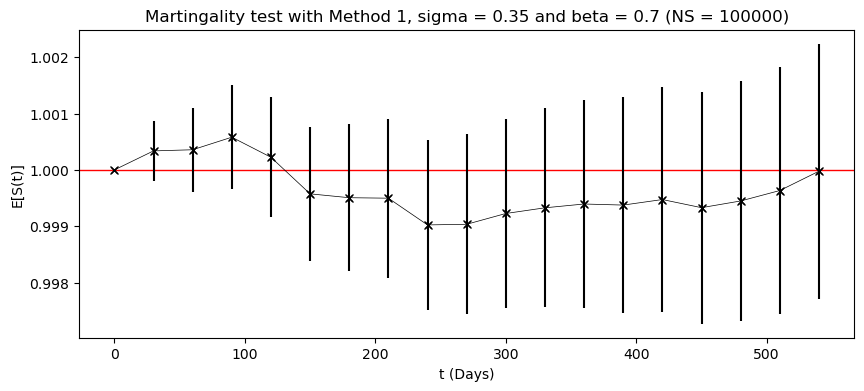

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0100 sec.
       30    1.000338      3.38e-04        5.29e-04      0.0101 sec.
       60    1.000365      3.65e-04        7.49e-04      0.0049 sec.
       90    1.000595      5.95e-04        9.19e-04      0.0049 sec.
      120    1.000240      2.40e-04        1.06e-03      0.0051 sec.
      150    0.999595      4.05e-04        1.19e-03      0.0047 sec.
      180    0.999531      4.69e-04        1.31e-03      0.0048 sec.
      210    0.999524      4.76e-04        1.41e-03      0.0046 sec.
      240    0.999053      9.47e-04        1.50e-03      0.0050 sec.
      270    0.999062      9.38e-04        1.59e-03      0.0049 sec.
      300    0.999252      7.48e-04        1.68e-03      0.0046 sec.
      330    0.999357      6.43e-04        1.76e-03      0.0045 sec.
      360    0.999426      5.74e-04        1.84e-03      0.0046 sec.
      390    0.999406      5.94e-04 

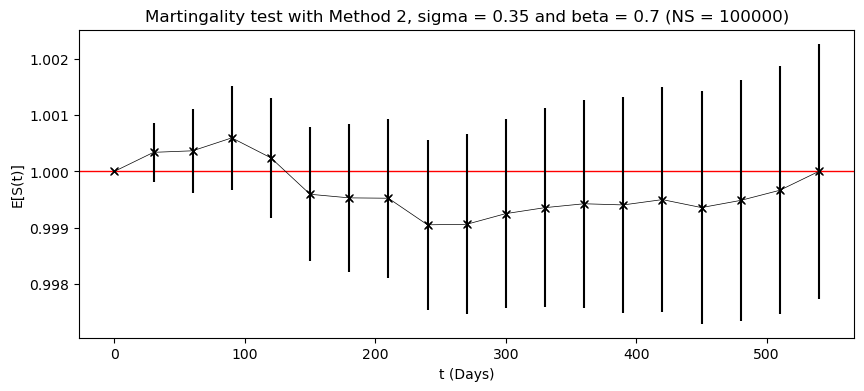

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0100 sec.
       30    1.000339      3.39e-04        5.29e-04      0.0044 sec.
       60    1.000363      3.63e-04        7.50e-04      0.0043 sec.
       90    1.000591      5.91e-04        9.21e-04      0.0053 sec.
      120    1.000245      2.45e-04        1.07e-03      0.0038 sec.
      150    0.999606      3.94e-04        1.19e-03      0.0041 sec.
      180    0.999548      4.52e-04        1.31e-03      0.0048 sec.
      210    0.999534      4.66e-04        1.41e-03      0.0046 sec.
      240    0.999044      9.56e-04        1.51e-03      0.0049 sec.
      270    0.999048      9.52e-04        1.60e-03      0.0043 sec.
      300    0.999239      7.61e-04        1.69e-03      0.0045 sec.
      330    0.999343      6.57e-04        1.77e-03      0.0041 sec.
      360    0.999395      6.05e-04        1.85e-03      0.0071 sec.
      390    0.999374      6.26e-04 

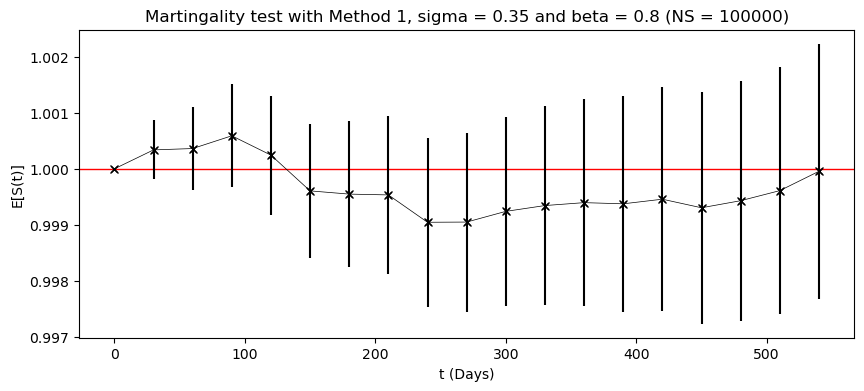

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0119 sec.
       30    1.000340      3.40e-04        5.29e-04      0.0052 sec.
       60    1.000371      3.71e-04        7.50e-04      0.0050 sec.
       90    1.000605      6.05e-04        9.21e-04      0.0114 sec.
      120    1.000261      2.61e-04        1.07e-03      0.0131 sec.
      150    0.999625      3.75e-04        1.19e-03      0.0116 sec.
      180    0.999572      4.28e-04        1.31e-03      0.0053 sec.
      210    0.999560      4.40e-04        1.41e-03      0.0131 sec.
      240    0.999073      9.27e-04        1.51e-03      0.0051 sec.
      270    0.999075      9.25e-04        1.60e-03      0.0051 sec.
      300    0.999264      7.36e-04        1.69e-03      0.0043 sec.
      330    0.999373      6.27e-04        1.77e-03      0.0129 sec.
      360    0.999427      5.73e-04        1.85e-03      0.0056 sec.
      390    0.999404      5.96e-04 

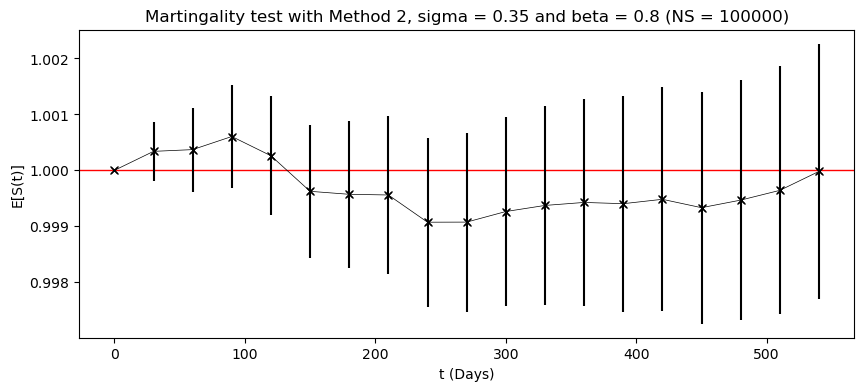

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0107 sec.
       30    1.000340      3.40e-04        5.29e-04      0.0042 sec.
       60    1.000369      3.69e-04        7.51e-04      0.0042 sec.
       90    1.000602      6.02e-04        9.22e-04      0.0044 sec.
      120    1.000267      2.67e-04        1.07e-03      0.0042 sec.
      150    0.999636      3.64e-04        1.20e-03      0.0042 sec.
      180    0.999590      4.10e-04        1.32e-03      0.0042 sec.
      210    0.999569      4.31e-04        1.42e-03      0.0044 sec.
      240    0.999066      9.34e-04        1.52e-03      0.0041 sec.
      270    0.999061      9.39e-04        1.61e-03      0.0043 sec.
      300    0.999251      7.49e-04        1.70e-03      0.0046 sec.
      330    0.999358      6.42e-04        1.79e-03      0.0109 sec.
      360    0.999393      6.07e-04        1.87e-03      0.0047 sec.
      390    0.999371      6.29e-04 

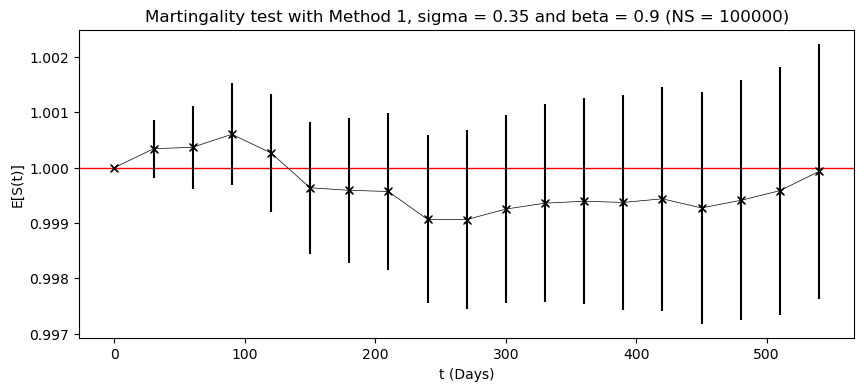

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0099 sec.
       30    1.000341      3.41e-04        5.29e-04      0.0044 sec.
       60    1.000377      3.77e-04        7.51e-04      0.0041 sec.
       90    1.000617      6.17e-04        9.23e-04      0.0042 sec.
      120    1.000283      2.83e-04        1.07e-03      0.0044 sec.
      150    0.999656      3.44e-04        1.20e-03      0.0044 sec.
      180    0.999614      3.86e-04        1.32e-03      0.0041 sec.
      210    0.999595      4.05e-04        1.42e-03      0.0043 sec.
      240    0.999094      9.06e-04        1.52e-03      0.0043 sec.
      270    0.999089      9.11e-04        1.61e-03      0.0044 sec.
      300    0.999276      7.24e-04        1.70e-03      0.0040 sec.
      330    0.999387      6.13e-04        1.79e-03      0.0042 sec.
      360    0.999424      5.76e-04        1.87e-03      0.0055 sec.
      390    0.999402      5.98e-04 

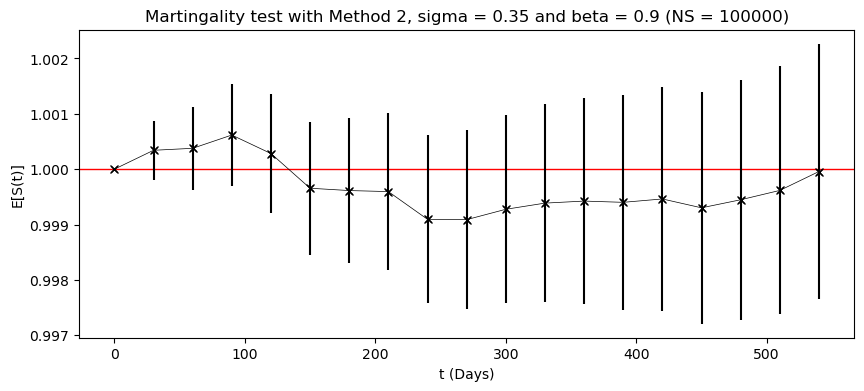

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0106 sec.
       30    1.000434      4.34e-04        6.79e-04      0.0041 sec.
       60    1.000458      4.58e-04        9.62e-04      0.0049 sec.
       90    1.000744      7.44e-04        1.18e-03      0.0059 sec.
      120    1.000288      2.88e-04        1.36e-03      0.0041 sec.
      150    0.999462      5.38e-04        1.53e-03      0.0047 sec.
      180    0.999371      6.29e-04        1.67e-03      0.0042 sec.
      210    0.999363      6.37e-04        1.81e-03      0.0042 sec.
      240    0.998748      1.25e-03        1.93e-03      0.0168 sec.
      270    0.998757      1.24e-03        2.04e-03      0.0110 sec.
      300    0.999014      9.86e-04        2.15e-03      0.0058 sec.
      330    0.999146      8.54e-04        2.26e-03      0.0055 sec.
      360    0.999238      7.62e-04        2.35e-03      0.0049 sec.
      390    0.999202      7.98e-04 

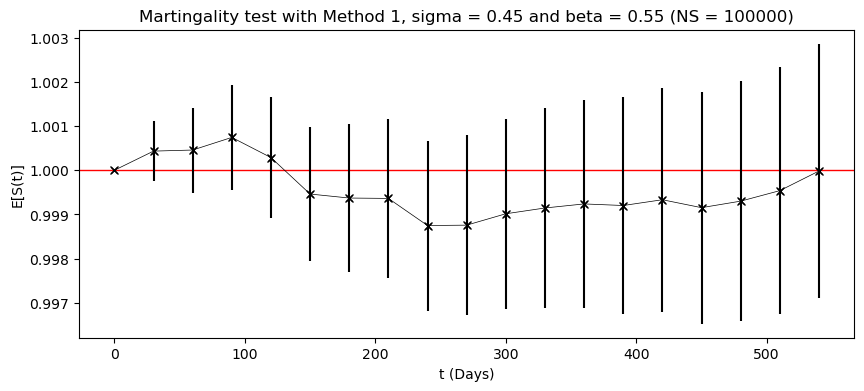

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0050 sec.
       30    1.000435      4.35e-04        6.79e-04      0.0048 sec.
       60    1.000471      4.71e-04        9.62e-04      0.0058 sec.
       90    1.000767      7.67e-04        1.18e-03      0.0047 sec.
      120    1.000314      3.14e-04        1.36e-03      0.0052 sec.
      150    0.999493      5.07e-04        1.53e-03      0.0048 sec.
      180    0.999411      5.89e-04        1.67e-03      0.0048 sec.
      210    0.999406      5.94e-04        1.81e-03      0.0056 sec.
      240    0.998796      1.20e-03        1.93e-03      0.0042 sec.
      270    0.998801      1.20e-03        2.04e-03      0.0065 sec.
      300    0.999055      9.45e-04        2.15e-03      0.0046 sec.
      330    0.999195      8.05e-04        2.26e-03      0.0070 sec.
      360    0.999289      7.11e-04        2.35e-03      0.0051 sec.
      390    0.999249      7.51e-04 

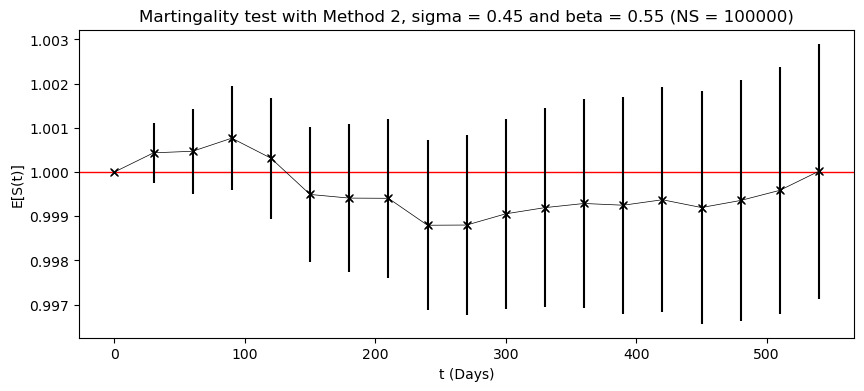

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0043 sec.
       30    1.000438      4.38e-04        6.80e-04      0.0043 sec.
       60    1.000472      4.72e-04        9.64e-04      0.0044 sec.
       90    1.000770      7.70e-04        1.18e-03      0.0039 sec.
      120    1.000339      3.39e-04        1.37e-03      0.0039 sec.
      150    0.999537      4.63e-04        1.53e-03      0.0039 sec.
      180    0.999473      5.27e-04        1.68e-03      0.0041 sec.
      210    0.999450      5.50e-04        1.82e-03      0.0041 sec.
      240    0.998800      1.20e-03        1.94e-03      0.0039 sec.
      270    0.998791      1.21e-03        2.06e-03      0.0042 sec.
      300    0.999047      9.53e-04        2.17e-03      0.0046 sec.
      330    0.999186      8.14e-04        2.28e-03      0.0041 sec.
      360    0.999242      7.58e-04        2.38e-03      0.0040 sec.
      390    0.999202      7.98e-04 

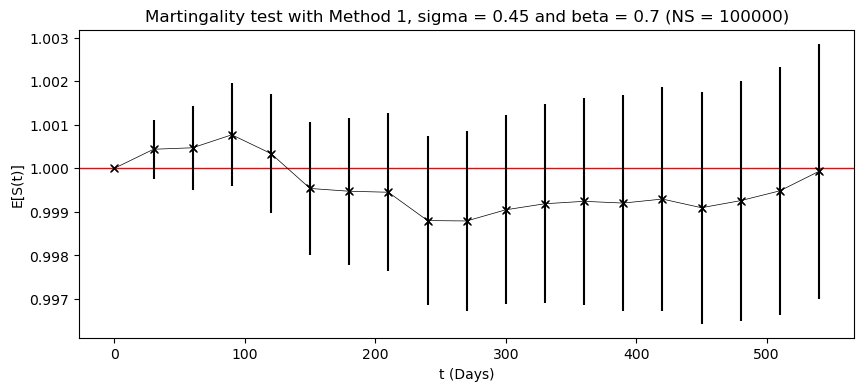

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0050 sec.
       30    1.000439      4.39e-04        6.80e-04      0.0051 sec.
       60    1.000485      4.85e-04        9.65e-04      0.0046 sec.
       90    1.000793      7.93e-04        1.18e-03      0.0048 sec.
      120    1.000365      3.65e-04        1.37e-03      0.0046 sec.
      150    0.999569      4.31e-04        1.53e-03      0.0045 sec.
      180    0.999513      4.87e-04        1.68e-03      0.0050 sec.
      210    0.999493      5.07e-04        1.82e-03      0.0042 sec.
      240    0.998847      1.15e-03        1.94e-03      0.0055 sec.
      270    0.998835      1.16e-03        2.06e-03      0.0053 sec.
      300    0.999088      9.12e-04        2.17e-03      0.0051 sec.
      330    0.999235      7.65e-04        2.28e-03      0.0043 sec.
      360    0.999293      7.07e-04        2.38e-03      0.0038 sec.
      390    0.999250      7.50e-04 

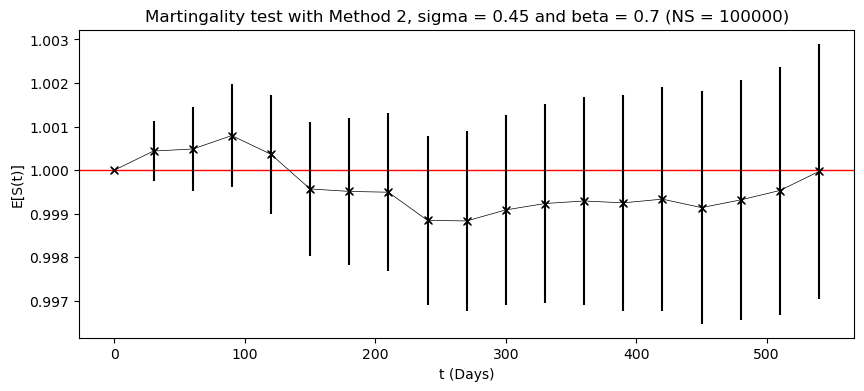

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0037 sec.
       30    1.000440      4.40e-04        6.80e-04      0.0048 sec.
       60    1.000482      4.82e-04        9.66e-04      0.0042 sec.
       90    1.000788      7.88e-04        1.19e-03      0.0041 sec.
      120    1.000375      3.75e-04        1.38e-03      0.0041 sec.
      150    0.999587      4.13e-04        1.54e-03      0.0038 sec.
      180    0.999543      4.57e-04        1.69e-03      0.0041 sec.
      210    0.999509      4.91e-04        1.83e-03      0.0040 sec.
      240    0.998836      1.16e-03        1.95e-03      0.0041 sec.
      270    0.998815      1.18e-03        2.07e-03      0.0041 sec.
      300    0.999067      9.33e-04        2.19e-03      0.0040 sec.
      330    0.999210      7.90e-04        2.30e-03      0.0040 sec.
      360    0.999237      7.63e-04        2.40e-03      0.0041 sec.
      390    0.999198      8.02e-04 

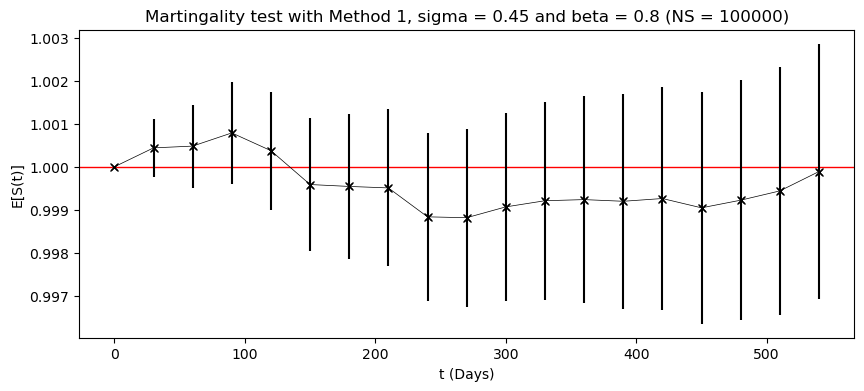

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0045 sec.
       30    1.000442      4.42e-04        6.81e-04      0.0043 sec.
       60    1.000495      4.95e-04        9.66e-04      0.0047 sec.
       90    1.000812      8.12e-04        1.19e-03      0.0055 sec.
      120    1.000401      4.01e-04        1.38e-03      0.0042 sec.
      150    0.999620      3.80e-04        1.54e-03      0.0043 sec.
      180    0.999582      4.18e-04        1.69e-03      0.0045 sec.
      210    0.999552      4.48e-04        1.83e-03      0.0045 sec.
      240    0.998883      1.12e-03        1.95e-03      0.0042 sec.
      270    0.998860      1.14e-03        2.07e-03      0.0048 sec.
      300    0.999107      8.93e-04        2.19e-03      0.0045 sec.
      330    0.999259      7.41e-04        2.30e-03      0.0047 sec.
      360    0.999288      7.12e-04        2.40e-03      0.0044 sec.
      390    0.999247      7.53e-04 

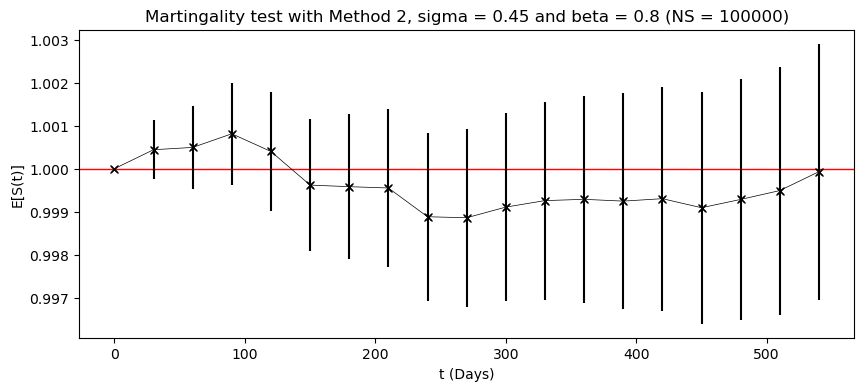

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0041 sec.
       30    1.000443      4.43e-04        6.81e-04      0.0040 sec.
       60    1.000492      4.92e-04        9.68e-04      0.0043 sec.
       90    1.000808      8.08e-04        1.19e-03      0.0039 sec.
      120    1.000413      4.13e-04        1.38e-03      0.0036 sec.
      150    0.999638      3.62e-04        1.55e-03      0.0044 sec.
      180    0.999614      3.86e-04        1.70e-03      0.0043 sec.
      210    0.999568      4.32e-04        1.84e-03      0.0045 sec.
      240    0.998874      1.13e-03        1.97e-03      0.0040 sec.
      270    0.998841      1.16e-03        2.09e-03      0.0041 sec.
      300    0.999086      9.14e-04        2.21e-03      0.0038 sec.
      330    0.999232      7.68e-04        2.33e-03      0.0040 sec.
      360    0.999225      7.75e-04        2.43e-03      0.0044 sec.
      390    0.999190      8.10e-04 

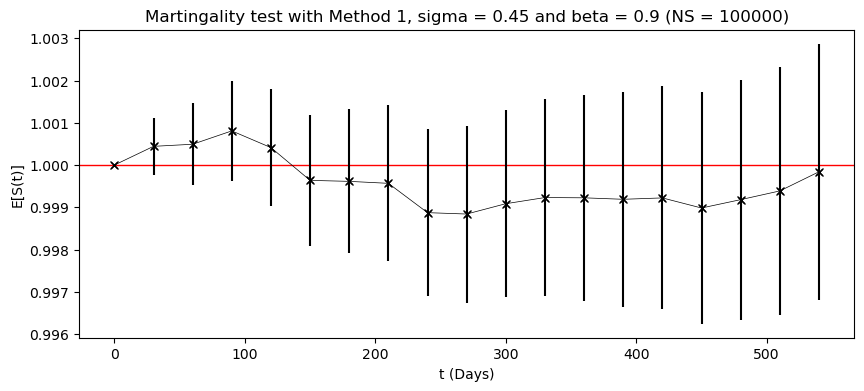

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0040 sec.
       30    1.000444      4.44e-04        6.81e-04      0.0041 sec.
       60    1.000506      5.06e-04        9.69e-04      0.0041 sec.
       90    1.000832      8.32e-04        1.19e-03      0.0038 sec.
      120    1.000439      4.39e-04        1.38e-03      0.0045 sec.
      150    0.999670      3.30e-04        1.55e-03      0.0040 sec.
      180    0.999653      3.47e-04        1.70e-03      0.0039 sec.
      210    0.999611      3.89e-04        1.84e-03      0.0038 sec.
      240    0.998922      1.08e-03        1.97e-03      0.0038 sec.
      270    0.998886      1.11e-03        2.09e-03      0.0040 sec.
      300    0.999126      8.74e-04        2.21e-03      0.0040 sec.
      330    0.999279      7.21e-04        2.33e-03      0.0041 sec.
      360    0.999277      7.23e-04        2.43e-03      0.0041 sec.
      390    0.999240      7.60e-04 

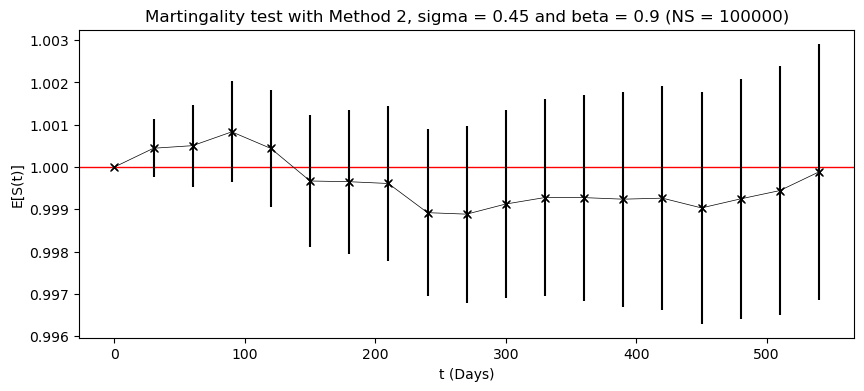

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0043 sec.
       30    1.000584      5.84e-04        9.06e-04      0.0044 sec.
       60    1.000628      6.28e-04        1.28e-03      0.0042 sec.
       90    1.001026      1.03e-03        1.57e-03      0.0040 sec.
      120    1.000462      4.62e-04        1.82e-03      0.0041 sec.
      150    0.999419      5.81e-04        2.04e-03      0.0041 sec.
      180    0.999334      6.66e-04        2.24e-03      0.0040 sec.
      210    0.999306      6.94e-04        2.41e-03      0.0043 sec.
      240    0.998420      1.58e-03        2.57e-03      0.0041 sec.
      270    0.998388      1.61e-03        2.73e-03      0.0042 sec.
      300    0.998760      1.24e-03        2.87e-03      0.0039 sec.
      330    0.998949      1.05e-03        3.01e-03      0.0042 sec.
      360    0.999026      9.74e-04        3.14e-03      0.0041 sec.
      390    0.998937      1.06e-03 

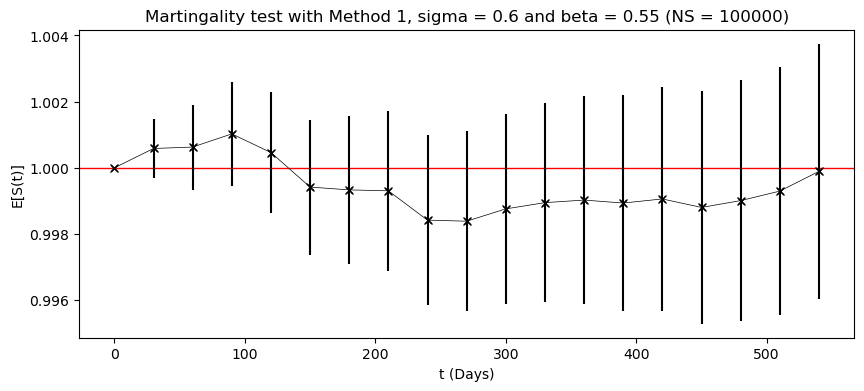

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0041 sec.
       30    1.000587      5.87e-04        9.06e-04      0.0043 sec.
       60    1.000651      6.51e-04        1.28e-03      0.0043 sec.
       90    1.001066      1.07e-03        1.58e-03      0.0039 sec.
      120    1.000507      5.07e-04        1.82e-03      0.0042 sec.
      150    0.999474      5.26e-04        2.04e-03      0.0041 sec.
      180    0.999404      5.96e-04        2.24e-03      0.0045 sec.
      210    0.999383      6.17e-04        2.41e-03      0.0038 sec.
      240    0.998504      1.50e-03        2.57e-03      0.0048 sec.
      270    0.998465      1.53e-03        2.73e-03      0.0042 sec.
      300    0.998829      1.17e-03        2.87e-03      0.0040 sec.
      330    0.999035      9.65e-04        3.01e-03      0.0043 sec.
      360    0.999115      8.85e-04        3.15e-03      0.0041 sec.
      390    0.999019      9.81e-04 

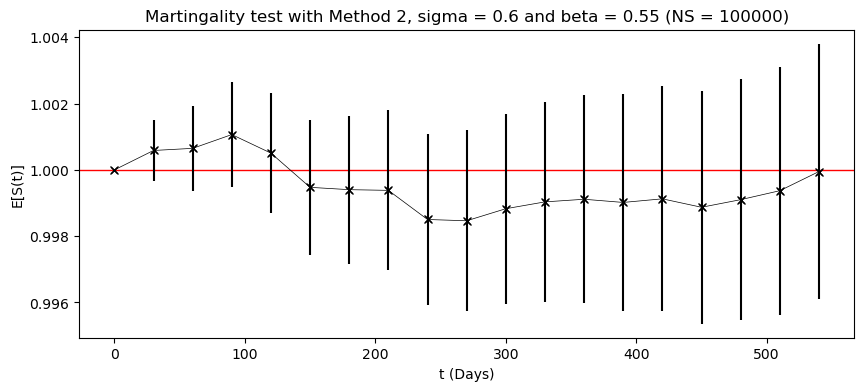

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0041 sec.
       30    1.000591      5.91e-04        9.07e-04      0.0041 sec.
       60    1.000654      6.54e-04        1.29e-03      0.0040 sec.
       90    1.001074      1.07e-03        1.58e-03      0.0038 sec.
      120    1.000556      5.56e-04        1.83e-03      0.0038 sec.
      150    0.999552      4.48e-04        2.05e-03      0.0038 sec.
      180    0.999519      4.81e-04        2.26e-03      0.0038 sec.
      210    0.999460      5.40e-04        2.44e-03      0.0040 sec.
      240    0.998519      1.48e-03        2.61e-03      0.0038 sec.
      270    0.998462      1.54e-03        2.77e-03      0.0038 sec.
      300    0.998817      1.18e-03        2.92e-03      0.0041 sec.
      330    0.999017      9.83e-04        3.07e-03      0.0037 sec.
      360    0.999021      9.79e-04        3.20e-03      0.0038 sec.
      390    0.998944      1.06e-03 

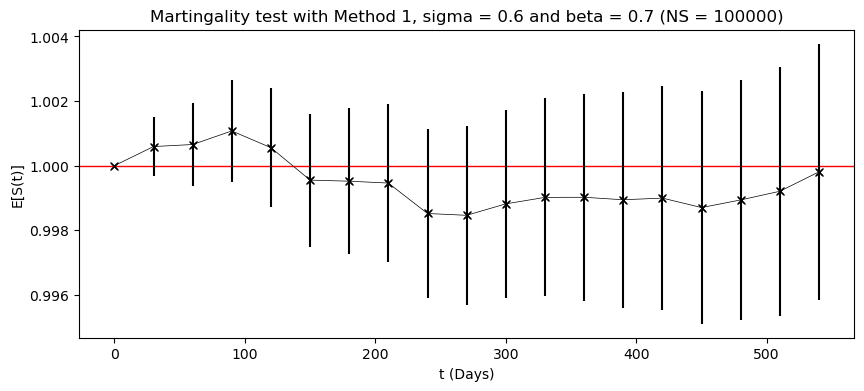

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0040 sec.
       30    1.000594      5.94e-04        9.08e-04      0.0042 sec.
       60    1.000678      6.78e-04        1.29e-03      0.0040 sec.
       90    1.001116      1.12e-03        1.58e-03      0.0041 sec.
      120    1.000601      6.01e-04        1.83e-03      0.0041 sec.
      150    0.999608      3.92e-04        2.06e-03      0.0041 sec.
      180    0.999588      4.12e-04        2.26e-03      0.0043 sec.
      210    0.999537      4.63e-04        2.44e-03      0.0040 sec.
      240    0.998602      1.40e-03        2.61e-03      0.0041 sec.
      270    0.998540      1.46e-03        2.77e-03      0.0041 sec.
      300    0.998886      1.11e-03        2.92e-03      0.0040 sec.
      330    0.999102      8.98e-04        3.07e-03      0.0043 sec.
      360    0.999111      8.89e-04        3.21e-03      0.0041 sec.
      390    0.999028      9.72e-04 

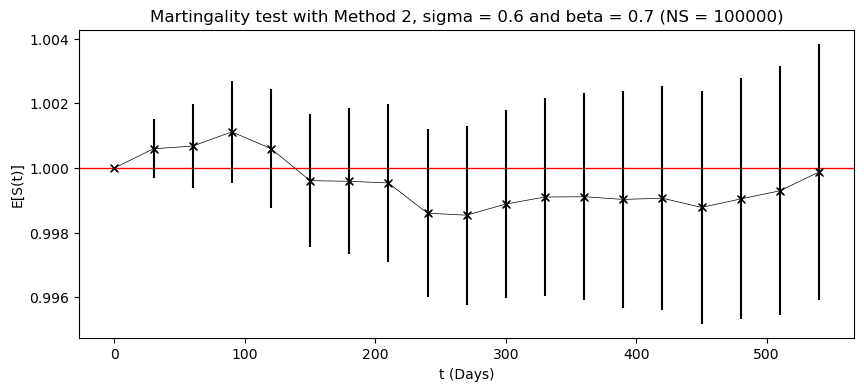

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0067 sec.
       30    1.000595      5.95e-04        9.09e-04      0.0042 sec.
       60    1.000673      6.73e-04        1.29e-03      0.0042 sec.
       90    1.001110      1.11e-03        1.59e-03      0.0041 sec.
      120    1.000623      6.23e-04        1.85e-03      0.0042 sec.
      150    0.999640      3.60e-04        2.07e-03      0.0041 sec.
      180    0.999645      3.55e-04        2.28e-03      0.0044 sec.
      210    0.999564      4.36e-04        2.46e-03      0.0041 sec.
      240    0.998589      1.41e-03        2.64e-03      0.0039 sec.
      270    0.998515      1.49e-03        2.80e-03      0.0041 sec.
      300    0.998850      1.15e-03        2.96e-03      0.0044 sec.
      330    0.999055      9.45e-04        3.12e-03      0.0042 sec.
      360    0.998999      1.00e-03        3.26e-03      0.0044 sec.
      390    0.998933      1.07e-03 

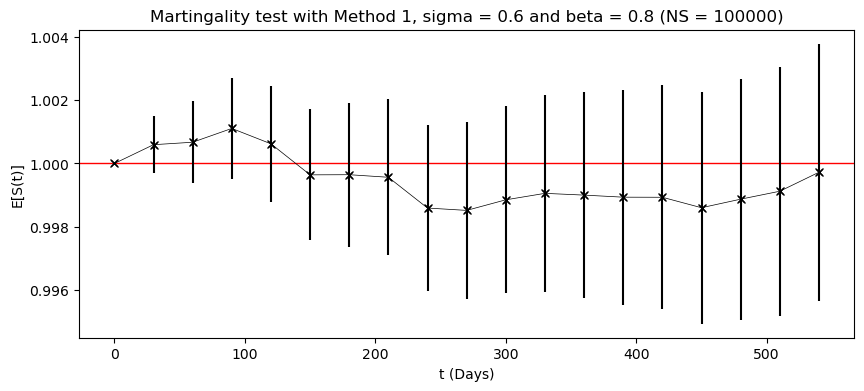

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0041 sec.
       30    1.000599      5.99e-04        9.09e-04      0.0043 sec.
       60    1.000698      6.98e-04        1.29e-03      0.0040 sec.
       90    1.001152      1.15e-03        1.59e-03      0.0044 sec.
      120    1.000669      6.69e-04        1.85e-03      0.0042 sec.
      150    0.999698      3.02e-04        2.07e-03      0.0039 sec.
      180    0.999713      2.87e-04        2.28e-03      0.0046 sec.
      210    0.999640      3.60e-04        2.47e-03      0.0039 sec.
      240    0.998672      1.33e-03        2.64e-03      0.0041 sec.
      270    0.998593      1.41e-03        2.80e-03      0.0042 sec.
      300    0.998919      1.08e-03        2.96e-03      0.0042 sec.
      330    0.999138      8.62e-04        3.12e-03      0.0041 sec.
      360    0.999090      9.10e-04        3.26e-03      0.0039 sec.
      390    0.999020      9.80e-04 

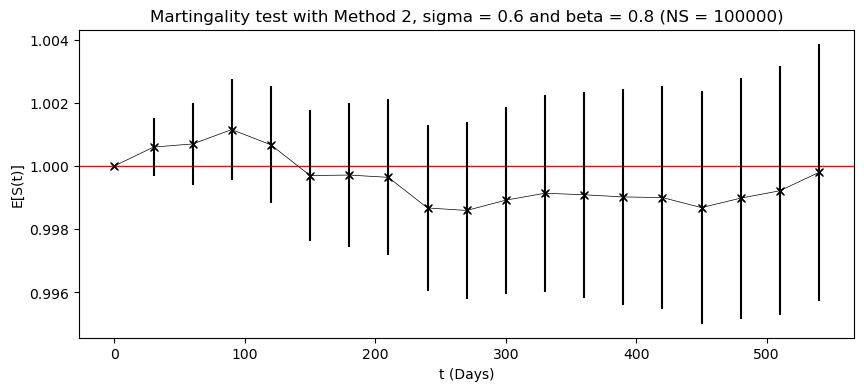

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0043 sec.
       30    1.000600      6.00e-04        9.11e-04      0.0043 sec.
       60    1.000694      6.94e-04        1.30e-03      0.0043 sec.
       90    1.001148      1.15e-03        1.60e-03      0.0041 sec.
      120    1.000695      6.95e-04        1.86e-03      0.0052 sec.
      150    0.999730      2.70e-04        2.09e-03      0.0045 sec.
      180    0.999776      2.24e-04        2.31e-03      0.0050 sec.
      210    0.999670      3.30e-04        2.50e-03      0.0043 sec.
      240    0.998668      1.33e-03        2.68e-03      0.0046 sec.
      270    0.998572      1.43e-03        2.85e-03      0.0044 sec.
      300    0.998880      1.12e-03        3.02e-03      0.0045 sec.
      330    0.999084      9.16e-04        3.18e-03      0.0041 sec.
      360    0.998958      1.04e-03        3.33e-03      0.0044 sec.
      390    0.998913      1.09e-03 

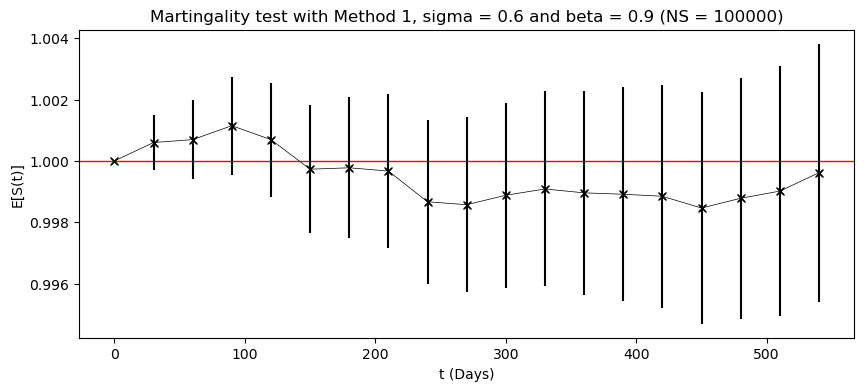

        t     E[S(t)]   |S(0)-E[S(t)]|      MC-err         elapsed
        0    1.000000      0.00e+00        0.00e+00      0.0041 sec.
       30    1.000604      6.04e-04        9.11e-04      0.0039 sec.
       60    1.000719      7.19e-04        1.30e-03      0.0043 sec.
       90    1.001192      1.19e-03        1.60e-03      0.0043 sec.
      120    1.000741      7.41e-04        1.86e-03      0.0040 sec.
      150    0.999788      2.12e-04        2.09e-03      0.0041 sec.
      180    0.999843      1.57e-04        2.31e-03      0.0044 sec.
      210    0.999747      2.53e-04        2.50e-03      0.0041 sec.
      240    0.998750      1.25e-03        2.68e-03      0.0045 sec.
      270    0.998650      1.35e-03        2.85e-03      0.0042 sec.
      300    0.998950      1.05e-03        3.02e-03      0.0043 sec.
      330    0.999167      8.33e-04        3.18e-03      0.0053 sec.
      360    0.999051      9.49e-04        3.33e-03      0.0042 sec.
      390    0.999003      9.97e-04 

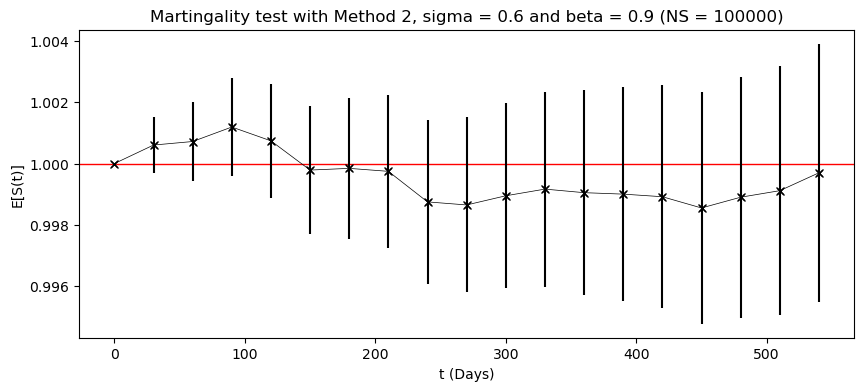

In [7]:
for s in sigma:
    for b in beta:
        martingale_property(S_t_met1(S_0, NS, Nt, s, b, dt, eps, normal), S_0, NS, s, b, 1)
        martingale_property(S_t_met2(S_0, NS, Nt, s, b, dt, eps, normal), S_0, NS, s, b, 2)

In [8]:
def MC_CEV(S,K,NS):
    
    prices = np.zeros((6,3))
    j = 0
    
    for i in [30,60,90,180,360,540]:

        payoff_c = np.where(S[:,i]>K,S[:,i]-K,0)
        price_c,std_c = stats(payoff_c)
        price_p = price_c + (K-1)
        err_c = 1.65 * std_c / sqrt(NS)
        prices[j,0] = price_p
        prices[j,1] = price_c
        prices[j,2] = err_c
        j += 1 
    
    return prices

In [9]:
def Analytic_CEV(K,beta,sigma,t,S_0):
    
    prices = np.zeros((6,2))
    
    for i in range(6):
        a = (K**(2*(1-beta))) / ((1-beta)**2 * sigma**2 * t[i])
        b = 1/(1-beta)
        c = ((S_0)**(2*(1-beta))) / ((1-beta)**2 * sigma**2 * t[i])
        prices[i,1] = S_0 *(1- ncx2.cdf(a, b+2, c)) - K * ncx2.cdf(c, b, a)
        prices[i,0] = -S_0 * ncx2.cdf(a, b+2, c) + K * (1-ncx2.cdf(c, b, a))
    
    return prices

In [10]:
#met1: first method for discretization
#met2: second method for discretization

In [16]:
for s in sigma:
    for d in beta:
        S1 = S_t_met1(S_0, NS, Nt, s, d, dt, eps,normal)
        S2 = S_t_met2(S_0, NS, Nt, s, d, dt, eps,normal)
        print("Prices computed with beta = {:.2f} and sigma = {:.2f}".format(d, s))
        print("\n%5s    %6s%4s    %7s   %7s       %6s      %7s  %7s       %6s    %7s  %7s" %("So","Strike", "t", "Put_met1","Call_met1", "Err", "Put_met2","Call_met2", "Err","Put_analytic","Call_analytic"))
        
        for i in range(len(Strikes)):
            cev1 = MC_CEV(S1,Strikes[i],NS)
            cev2 = MC_CEV(S2,Strikes[i],NS)
            an = Analytic_CEV(Strikes[i],d,s,t,S_0)
            for x,y,z,w in zip(t,cev1,cev2,an):
                print("%6.3f  %6.3f %6.3f  %7.4f    %7.4f     +/-  %7.1e    %7.4f    %7.4f    +/-  %7.1e    %7.4f       %7.4f" %(S_0, Strikes[i], x,y[0],y[1],y[2],z[0],z[1],z[2],w[0],w[1])) 
            print('\n')
        print('\n')
        print("#################################################################################################################################")     
        print('\n')

Prices computed with beta = 0.55 and sigma = 0.20

   So    Strike   t    Put_met1   Call_met1          Err      Put_met2  Call_met2          Err    Put_analytic  Call_analytic
 1.000   0.800  0.083   0.0002     0.2002     +/-  3.0e-04     0.0002     0.2002    +/-  3.0e-04     0.0000        0.2000
 1.000   0.800  0.167   0.0003     0.2003     +/-  4.3e-04     0.0003     0.2003    +/-  4.3e-04     0.0001        0.2001
 1.000   0.800  0.250   0.0009     0.2009     +/-  5.2e-04     0.0009     0.2009    +/-  5.2e-04     0.0006        0.2006
 1.000   0.800  0.500   0.0036     0.2036     +/-  7.1e-04     0.0036     0.2036    +/-  7.1e-04     0.0039        0.2039
 1.000   0.800  1.000   0.0137     0.2137     +/-  9.4e-04     0.0137     0.2137    +/-  9.4e-04     0.0139        0.2139
 1.000   0.800  1.500   0.0246     0.2246     +/-  1.1e-03     0.0246     0.2246    +/-  1.1e-03     0.0245        0.2245


 1.000   0.900  0.083   0.0010     0.1010     +/-  2.9e-04     0.0010     0.1010    +/-  

In [12]:
def BS_Price_Call_Put(r,q,T,K,sigma,So):
    
    prices = np.zeros((6,2))
    j=0
    for i in T:
        F = So * exp((r-q)*i)
        d = (log(K/F) + (sigma**2 * i / 2))/ sigma
        n1 = norm.cdf(d/(sqrt(i)))
        n2 = norm.cdf((d-sigma*i)/(sqrt(i)))
        price_p = exp(-r*i) * (K*n1 - F*n2)
        price_c = price_p + (1-K)
        prices[j,0] = price_p
        prices[j,1] = price_c
        j += 1
    
    return prices

In [13]:
for s in sigma: 
    print("Prices computed using MC Vs prices computed using BS with beta = {:.2f} and sigma = {:.2f}".format(1, s))
    print("\n%5s    %6s%4s    %7s   %7s       %6s      %7s     %7s" %("So","Strike", "t", "Put_met1","Call_met1", "Err","Put_BS","Call_BS"))
    S1 = S_t_met1(S_0, NS, Nt, s, 1, dt, eps,normal)
    
    for i in range(len(Strikes)):
        cev1 = MC_CEV(S1,Strikes[i],NS)
        bs = BS_Price_Call_Put(0,0,t,Strikes[i],s,S_0)
        
        for x,y,z in zip(t,cev1,bs):
            print("%6.3f  %6.3f %6.3f  %7.4f    %7.4f     +/-  %7.1e    %7.4f    %7.4f" %(S_0, Strikes[i], x,y[0],y[1],y[2],z[0],z[1])) 
    print('\n')       
    print("#################################################################################################################################")     
    print('\n')

Prices computed using MC Vs prices computed using BS with beta = 1.00 and sigma = 0.20

   So    Strike   t    Put_met1   Call_met1          Err       Put_BS     Call_BS
 1.000   0.800  0.083   0.0002     0.2002     +/-  3.0e-04     0.0000     0.2000
 1.000   0.800  0.167   0.0003     0.2003     +/-  4.3e-04     0.0001     0.2001
 1.000   0.800  0.250   0.0007     0.2007     +/-  5.2e-04     0.0004     0.2004
 1.000   0.800  0.500   0.0029     0.2029     +/-  7.2e-04     0.0031     0.2031
 1.000   0.800  1.000   0.0117     0.2117     +/-  9.7e-04     0.0119     0.2119
 1.000   0.800  1.500   0.0215     0.2215     +/-  1.2e-03     0.0215     0.2215

   So    Strike   t    Put_met1   Call_met1          Err       Put_BS     Call_BS
 1.000   0.900  0.083   0.0009     0.1009     +/-  2.9e-04     0.0007     0.1007
 1.000   0.900  0.167   0.0038     0.1038     +/-  4.0e-04     0.0036     0.1036
 1.000   0.900  0.250   0.0074     0.1074     +/-  4.7e-04     0.0071     0.1071
 1.000   0.900  0.

Implied volatilities with beta = 0.55 and sigma = 0.20


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.315649  0.213423  0.204501  0.202513  0.200984    0.1998  0.196298  0.193769
2M   0.236625   0.20714   0.20344  0.202032   0.20103  0.200093  0.197348  0.192651
3M   0.224304  0.207469  0.203872  0.202528  0.201385  0.200397  0.197451  0.192901
6M   0.206746  0.204928  0.202918  0.201894   0.20093  0.199964  0.196674   0.19321
1Y   0.209434  0.204534  0.202077  0.200917  0.199779  0.198654  0.195556  0.191638
18M  0.210598  0.205009  0.202415  0.201158   0.19995  0.198785  0.195497  0.191576




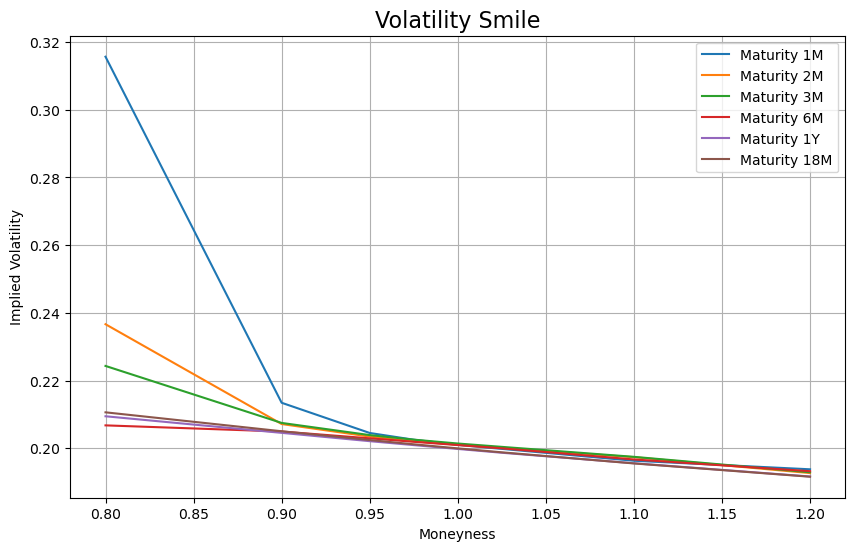

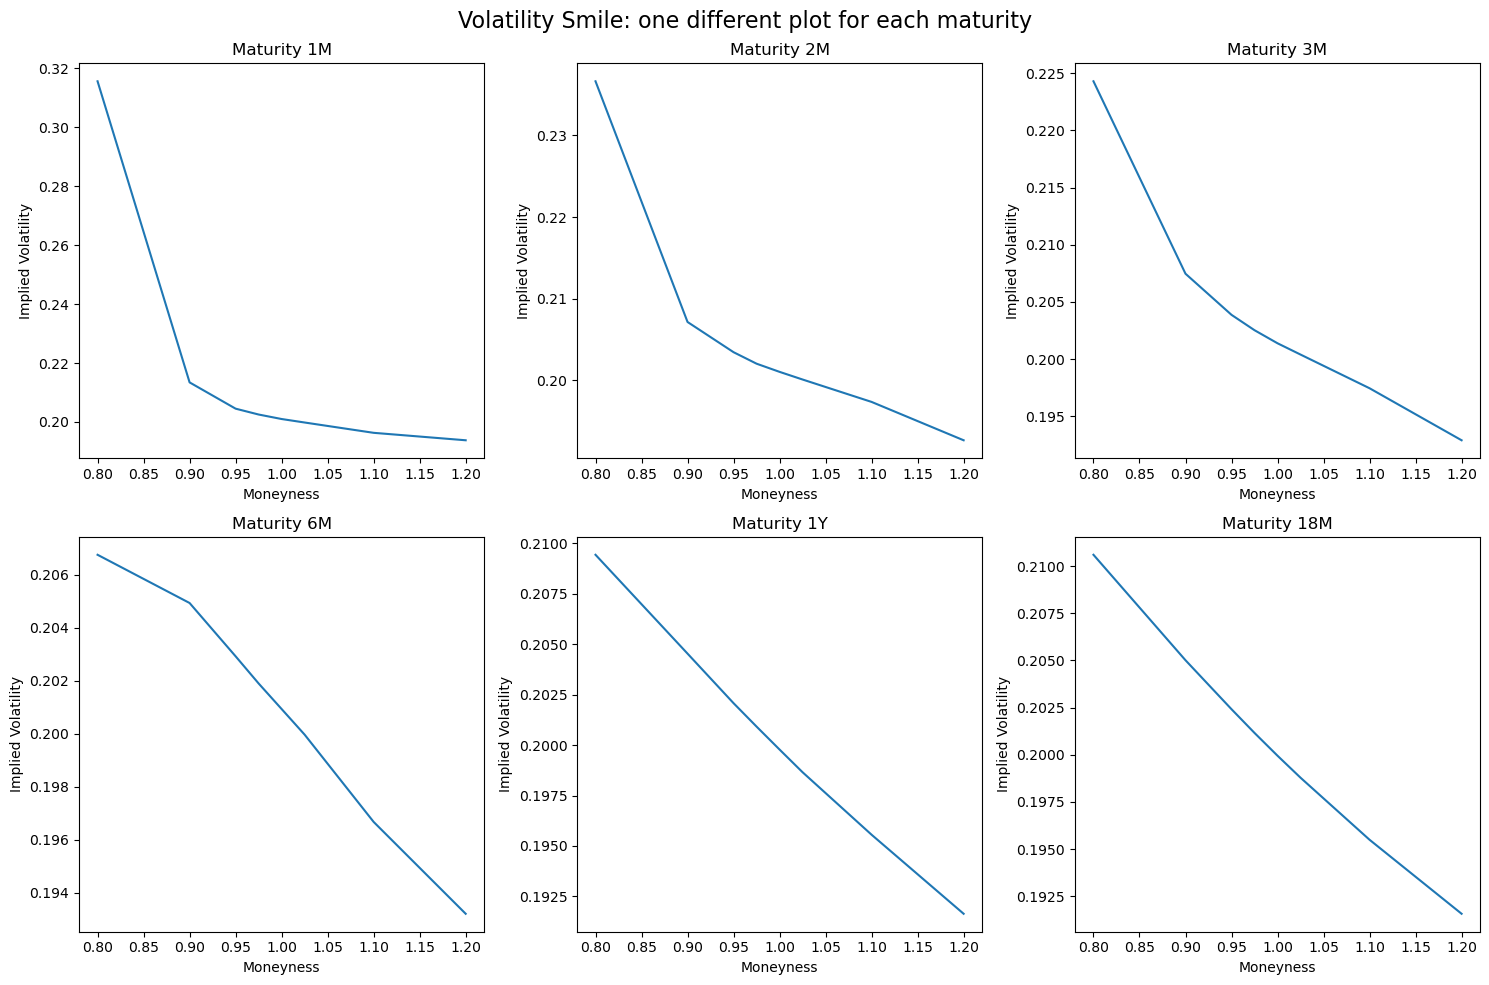

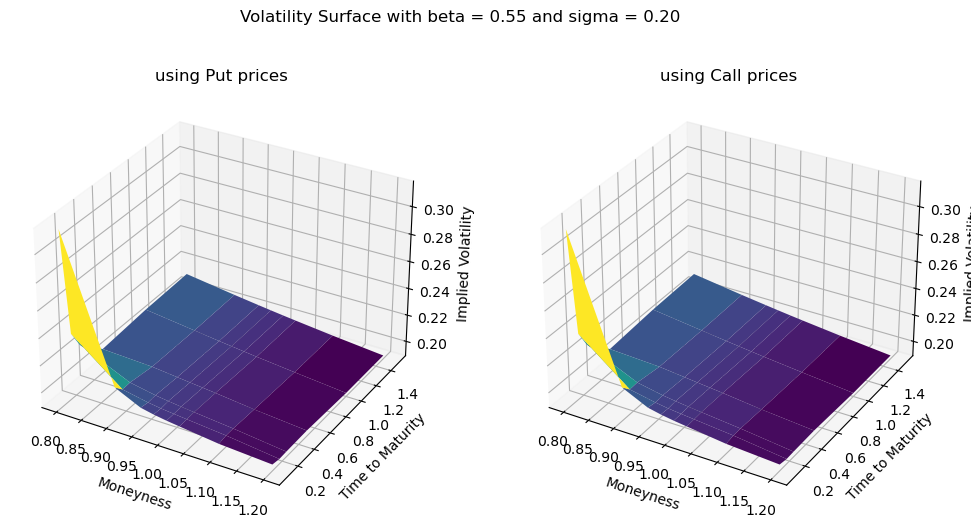



Implied volatilities with beta = 0.70 and sigma = 0.20


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M    0.31572  0.212087  0.203767  0.202153  0.200992  0.200166  0.197667  0.196293
2M   0.235287  0.205637    0.2027  0.201678  0.201051  0.200479  0.198756  0.195335
3M   0.221949  0.205945  0.203131  0.202175  0.201407  0.200784  0.198867   0.19555
6M   0.203322  0.203376  0.202174  0.201537  0.200956  0.200348  0.198093  0.195884
1Y   0.205916   0.20288  0.201248  0.200492  0.199728  0.198975  0.196919  0.194256
18M   0.20707  0.203326  0.201554  0.200696  0.199872  0.199081  0.196837  0.194183




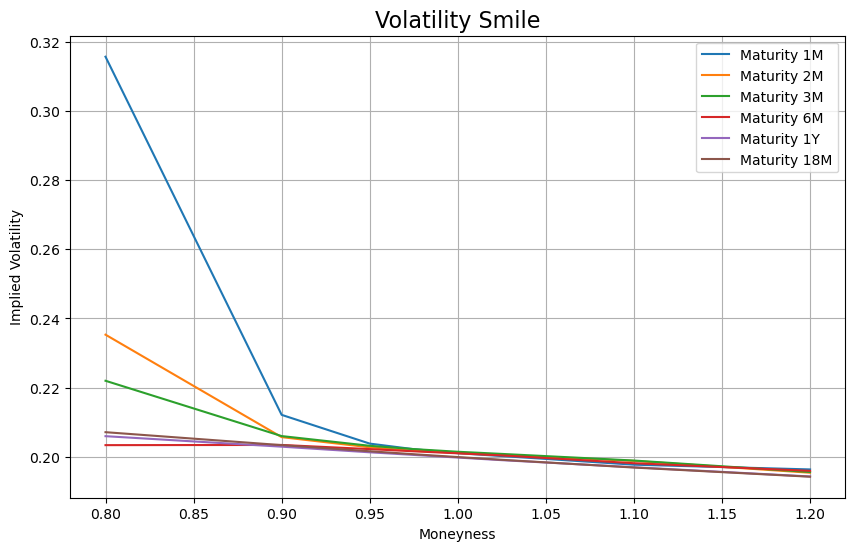

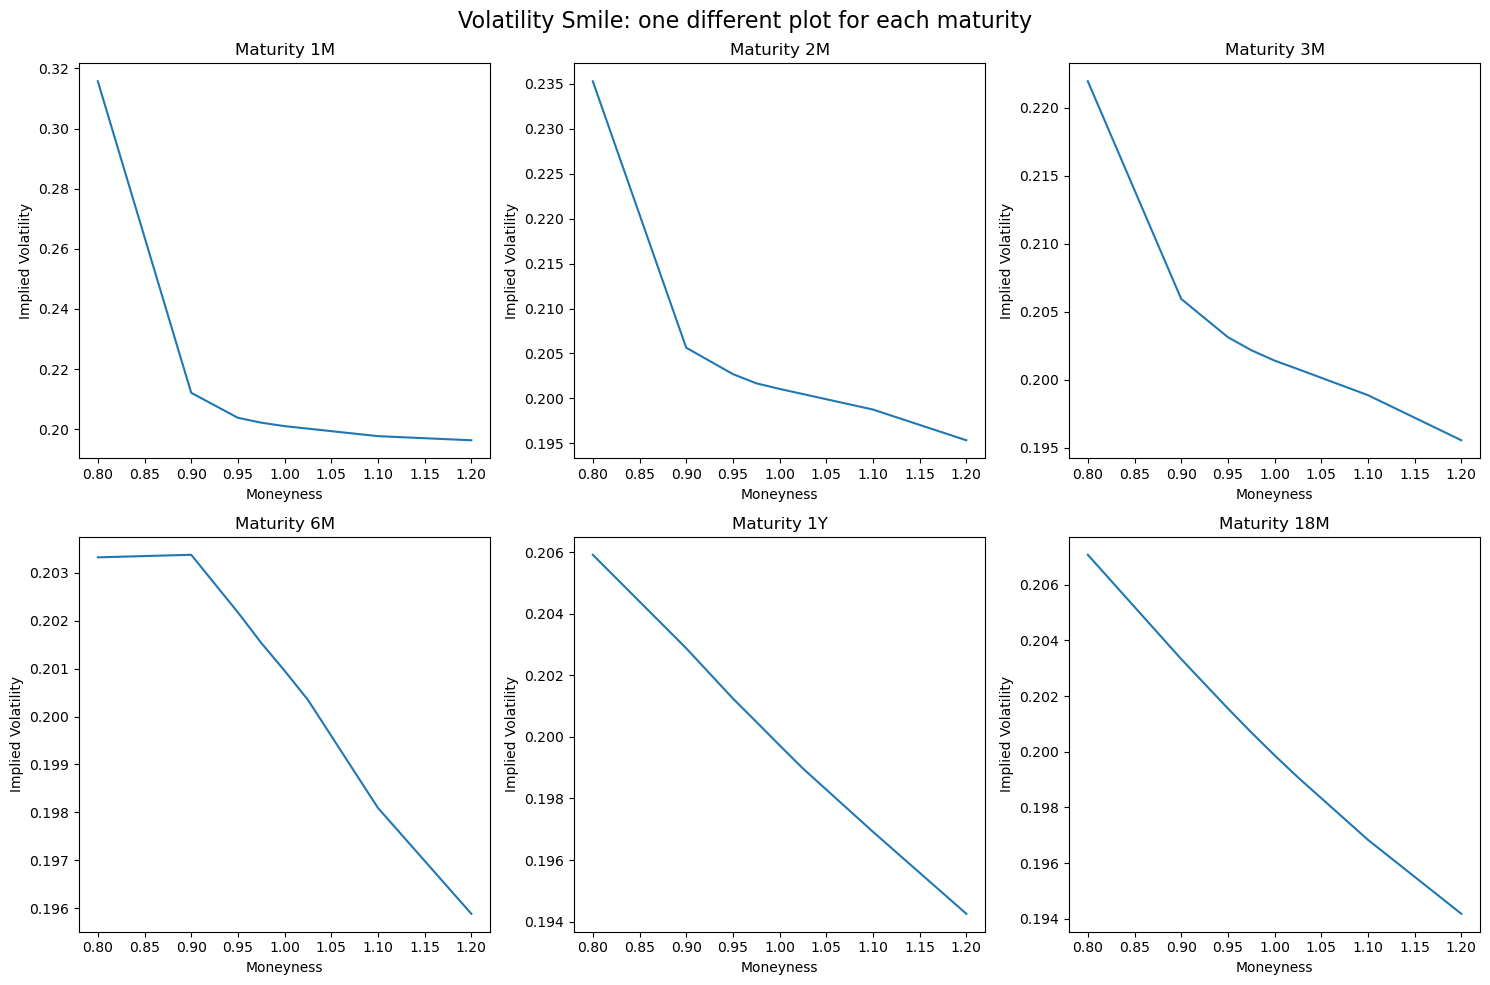

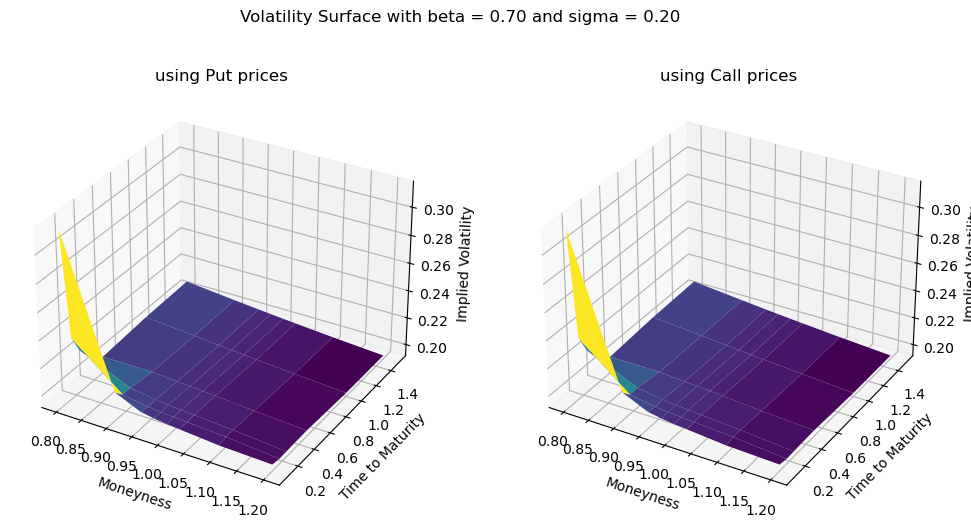



Implied volatilities with beta = 0.80 and sigma = 0.20


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.315773  0.211207   0.20328  0.201914  0.200999  0.200411  0.198585  0.198014
2M   0.234475  0.204643   0.20221  0.201446  0.201067  0.200738    0.1997  0.197151
3M   0.220458  0.204938  0.202641  0.201944  0.201425  0.201046  0.199818  0.197332
6M   0.201071  0.202352  0.201686  0.201304  0.200978  0.200609  0.199048  0.197684
1Y     0.2036   0.20179  0.200706  0.200215  0.199703  0.199197  0.197838  0.196019
18M  0.204754   0.20222  0.200993  0.200398  0.199831  0.199287  0.197742  0.195943




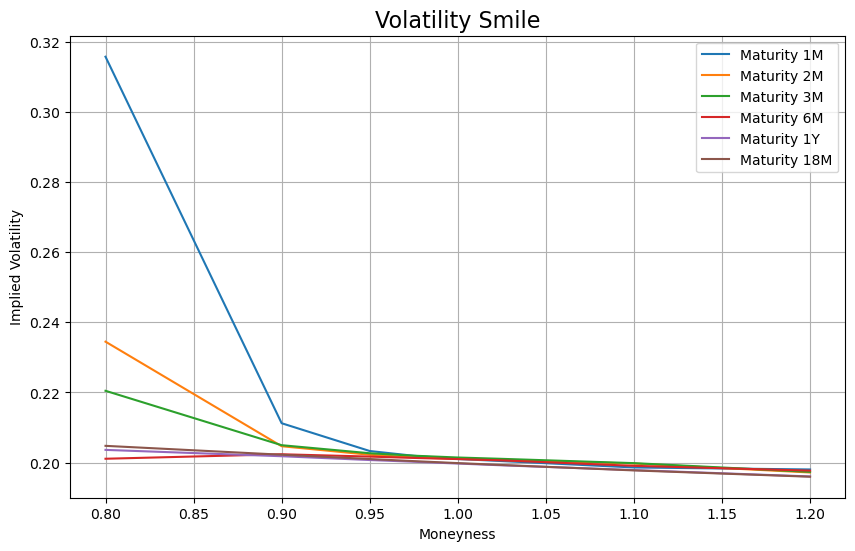

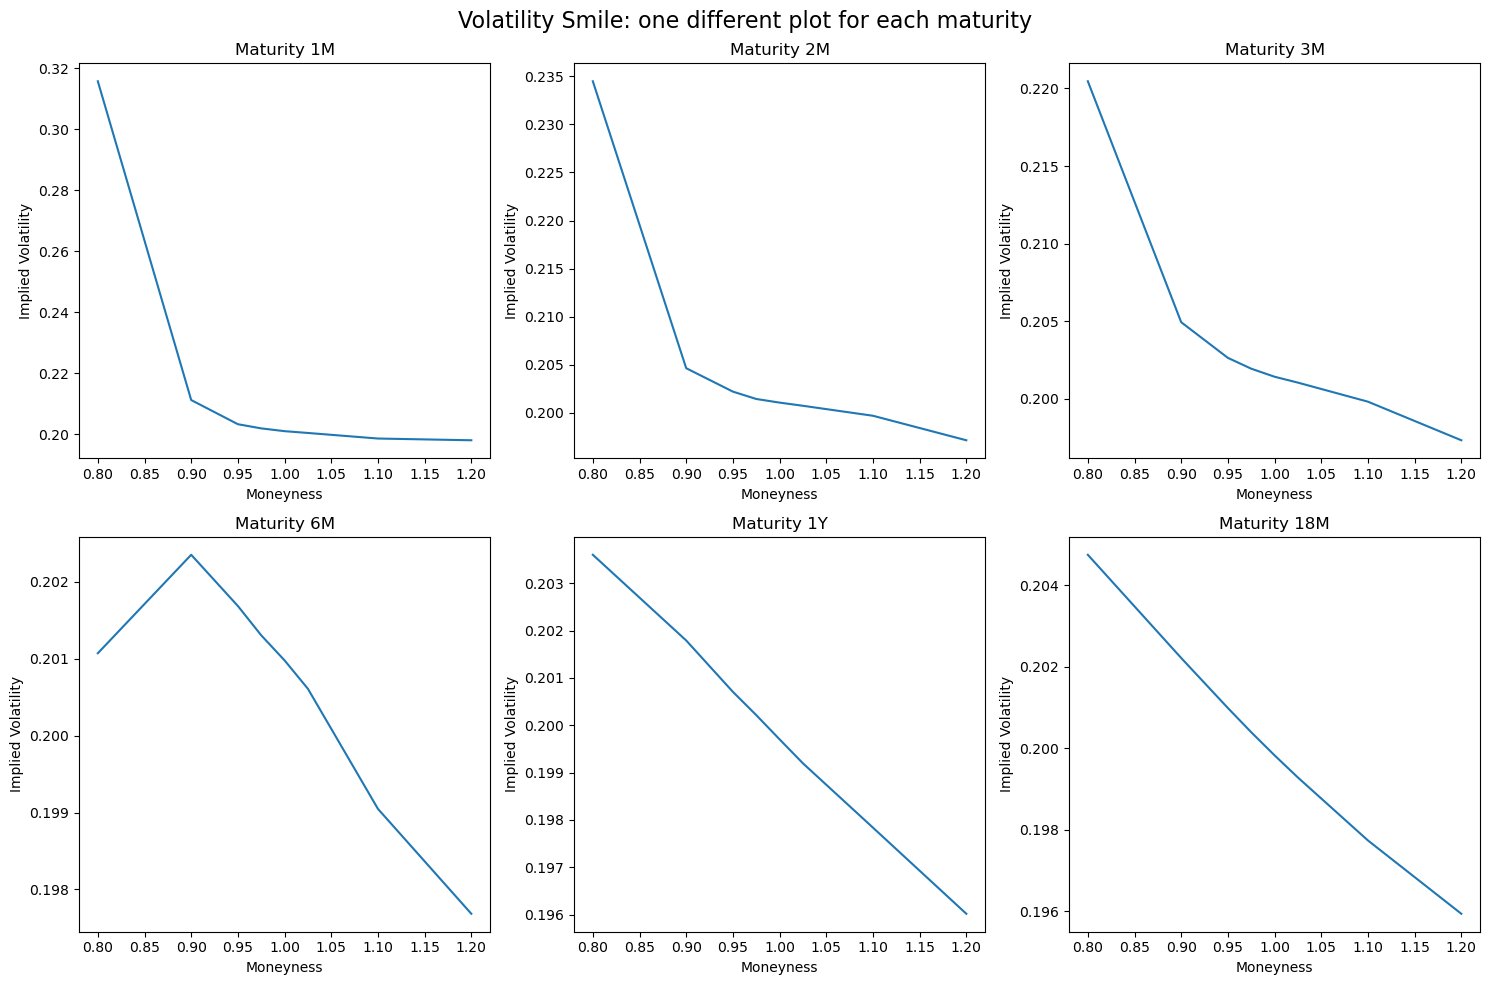

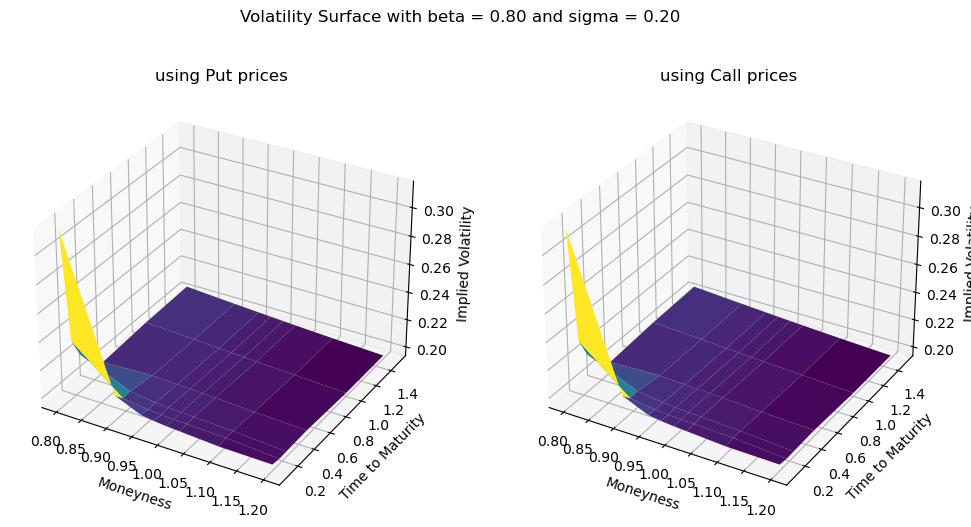



Implied volatilities with beta = 0.90 and sigma = 0.20


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.315836  0.210333  0.202795  0.201676  0.201006  0.200658  0.199506  0.199758
2M   0.233731  0.203657  0.201722  0.201215  0.201084  0.200999  0.200648  0.198987
3M    0.21903  0.203937  0.202154  0.201715  0.201445   0.20131  0.200774  0.199131
6M   0.198847  0.201336  0.201203  0.201077  0.201005  0.200874  0.200011  0.199499
1Y   0.201305   0.20071  0.200171  0.199942  0.199684  0.199425  0.198767  0.197799
18M  0.202463  0.201129  0.200444  0.200112  0.199799  0.199502  0.198658  0.197723




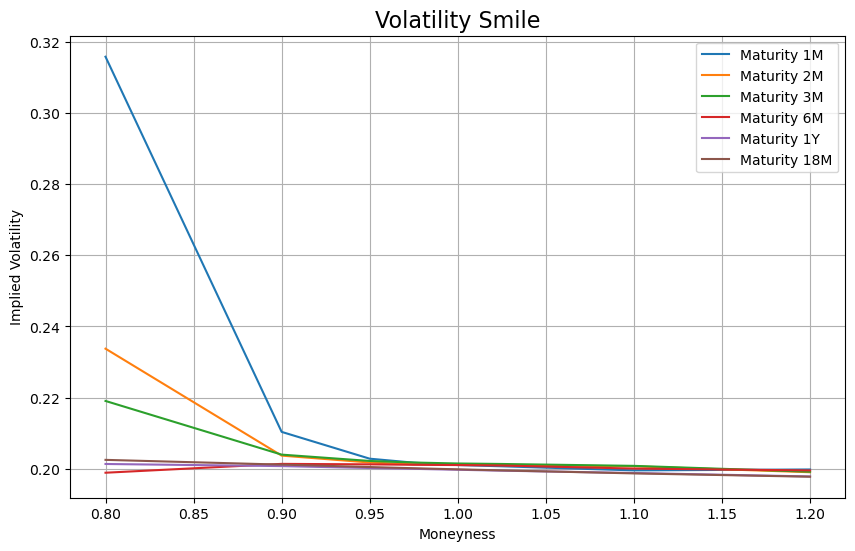

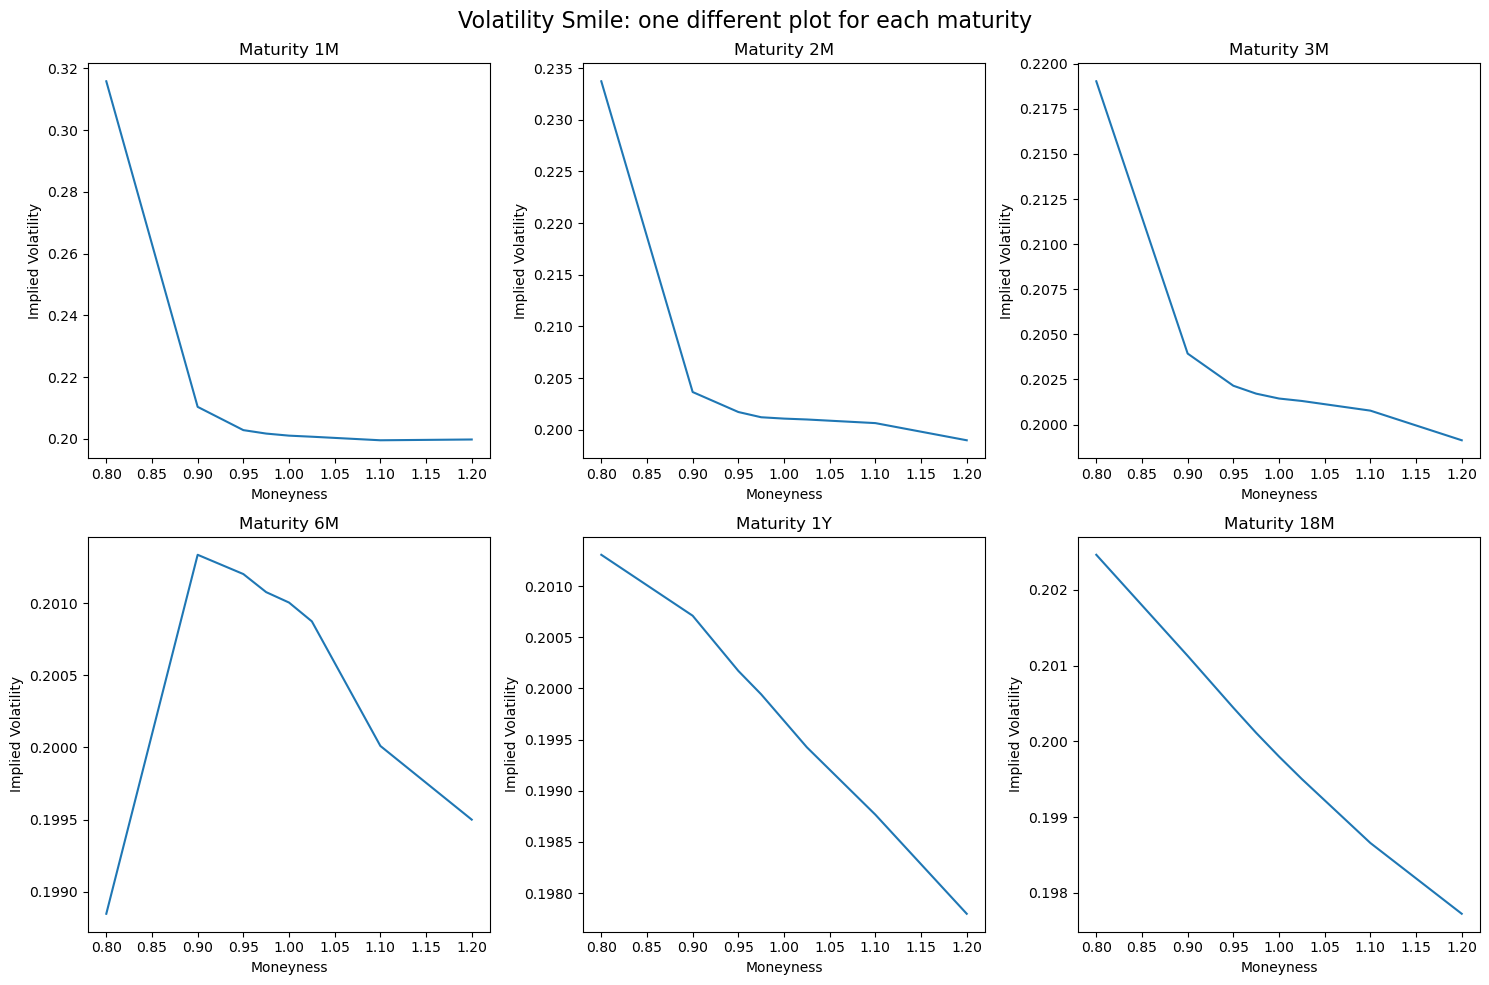

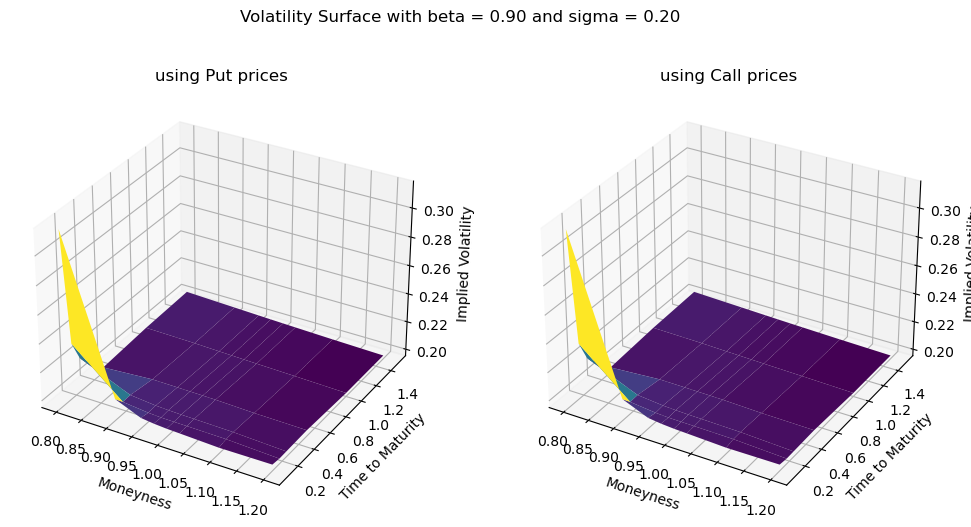



Implied volatilities with beta = 0.55 and sigma = 0.35


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.394978  0.363295  0.356798  0.354205  0.351797  0.349725  0.343964  0.336517
2M   0.374521    0.3608  0.355839  0.353816  0.351971  0.350094   0.34529  0.338441
3M   0.374697  0.361623  0.356775  0.354651  0.352635  0.350778  0.345545  0.338679
6M   0.368155  0.359737  0.355693  0.353771  0.351961  0.350149  0.344534  0.337673
1Y   0.367566  0.358125  0.353865  0.351798  0.349802  0.347823  0.342381  0.335694
18M  0.368661  0.358828  0.354345  0.352209  0.350153  0.348156  0.342484  0.335608




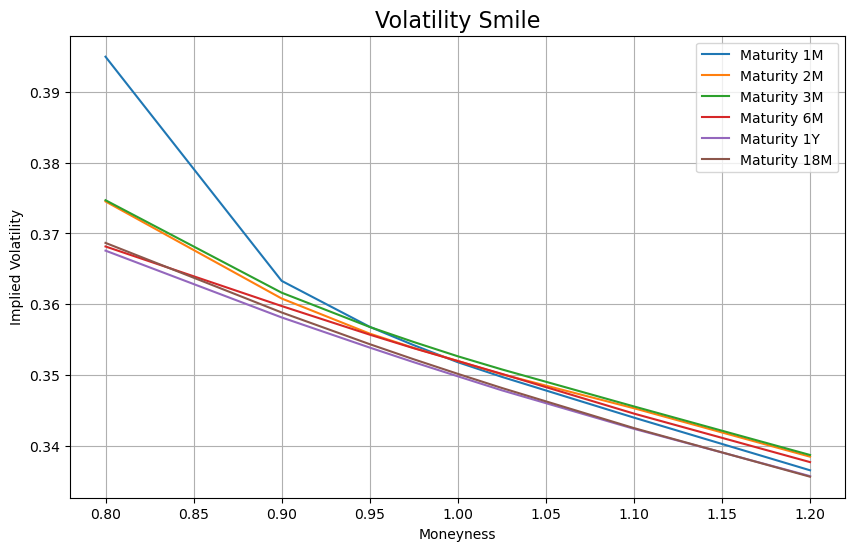

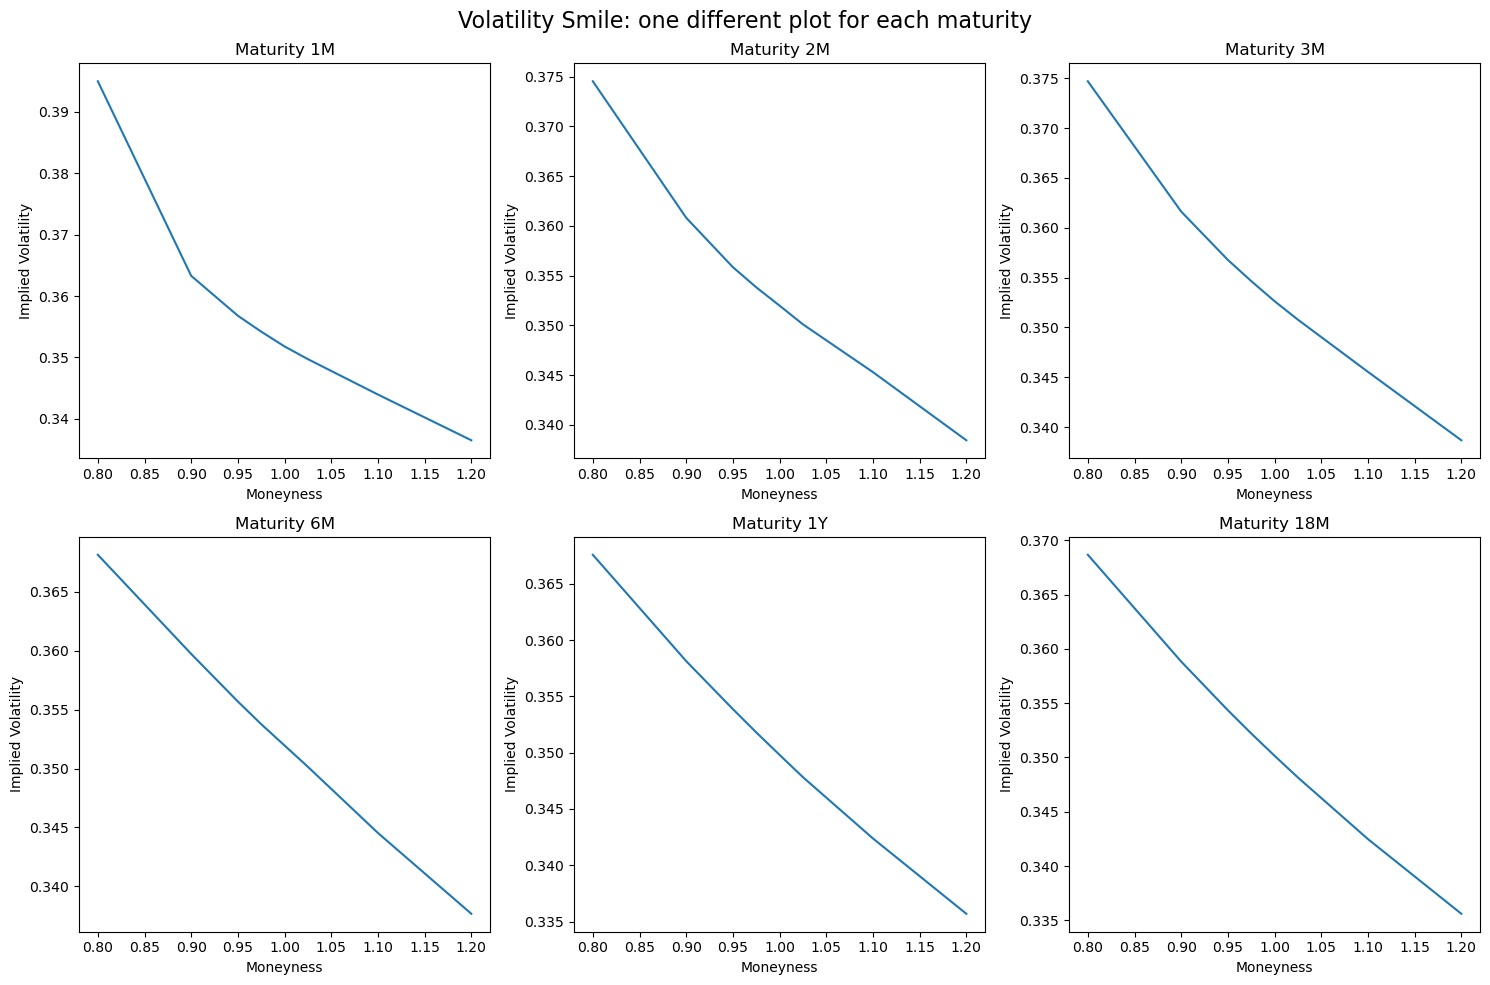

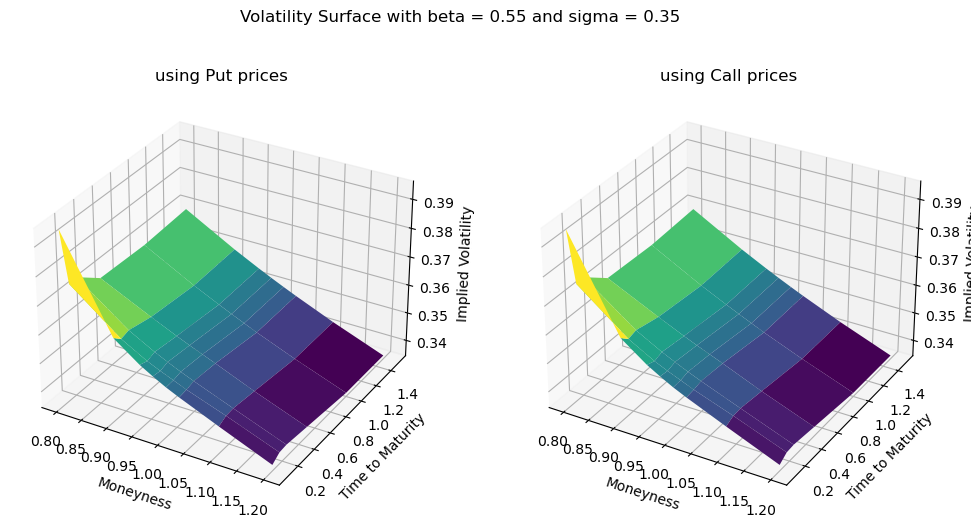



Implied volatilities with beta = 0.70 and sigma = 0.35


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.390668  0.360648  0.355512  0.353586  0.351818  0.350369  0.346372  0.341034
2M   0.368987  0.358118  0.354562  0.353219  0.352025   0.35078   0.34776  0.343093
3M   0.369038  0.358924  0.355497  0.354048  0.352692   0.35148  0.348042  0.343352
6M   0.362284  0.357001  0.354382   0.35316  0.352005  0.350814  0.346985  0.342349
1Y   0.361274  0.355063  0.352267  0.350892  0.349555  0.348243  0.344642  0.340173
18M  0.362207  0.355615    0.3526  0.351173  0.349781  0.348447   0.34462  0.339978




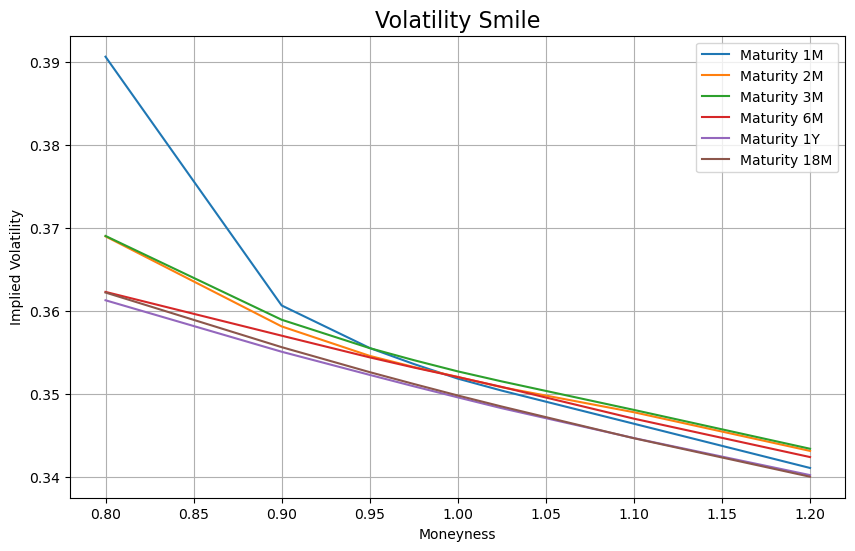

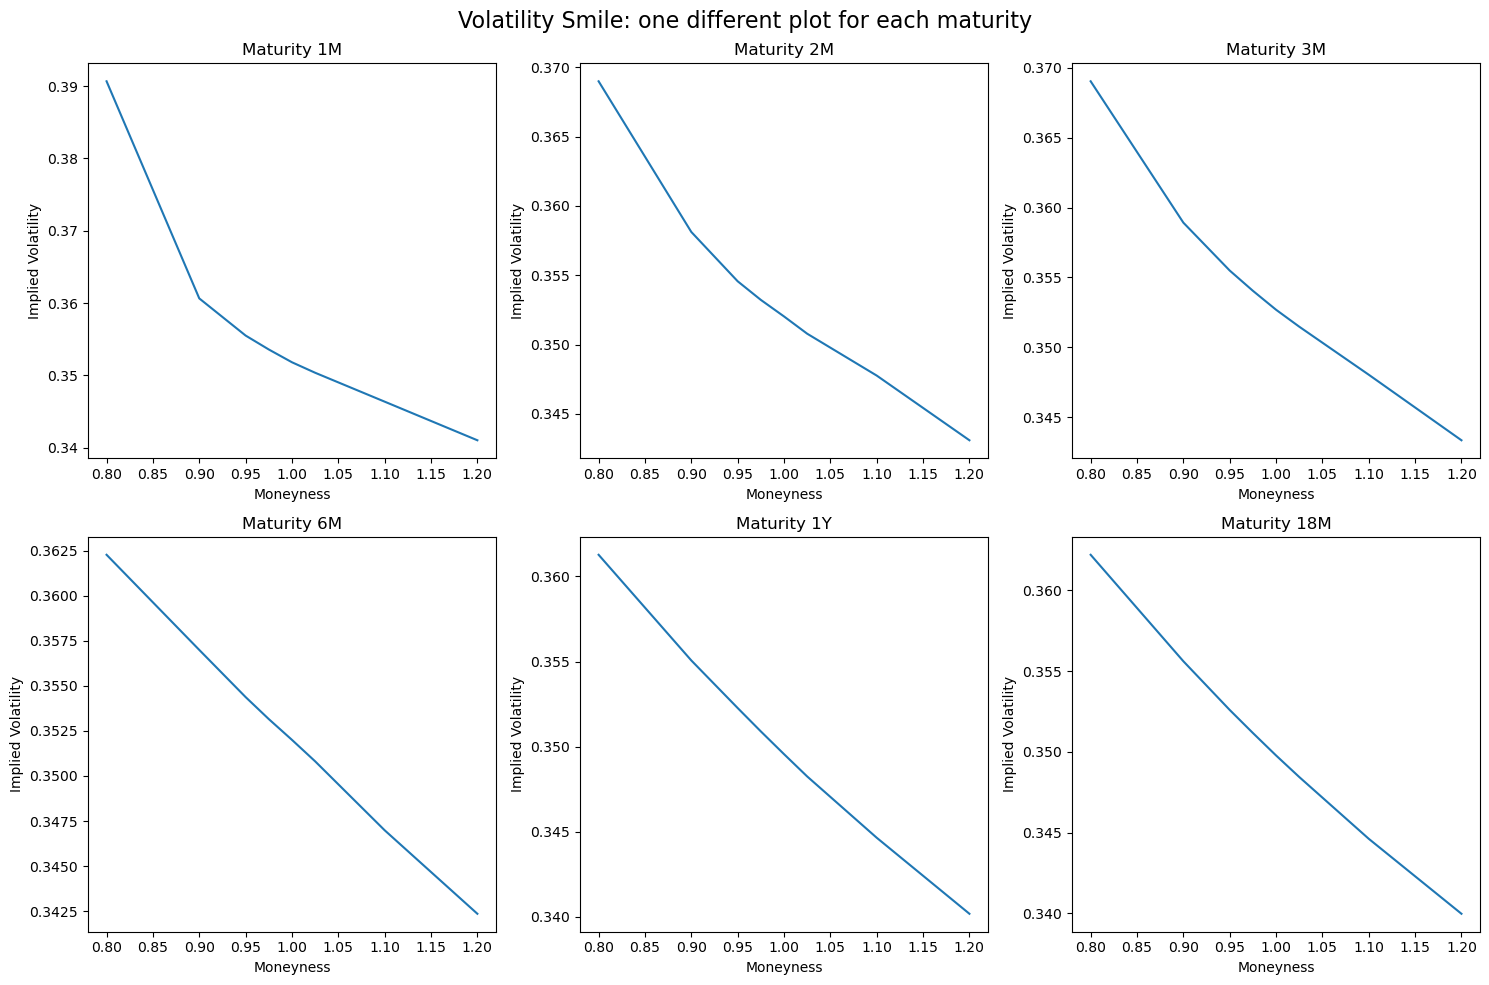

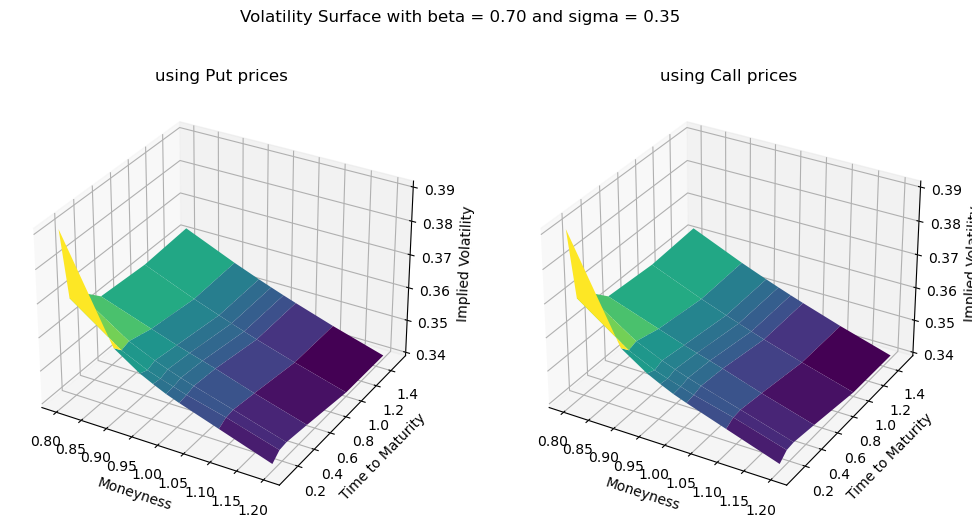



Implied volatilities with beta = 0.80 and sigma = 0.35


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.387905  0.358898  0.354662  0.353179  0.351836  0.350804  0.347989  0.344073
2M   0.365365   0.35635  0.353725  0.352832   0.35207  0.351248  0.349423  0.346228
3M   0.365335   0.35715  0.354664  0.353661  0.352746  0.351964  0.349728  0.346504
6M   0.358445  0.355218  0.353543  0.352784  0.352064   0.35129  0.348652  0.345514
1Y   0.357164   0.35308  0.351244   0.35033  0.349428  0.348563  0.346191  0.343216
18M  0.358025  0.353554  0.351505  0.350545  0.349608    0.3487  0.346104  0.342956




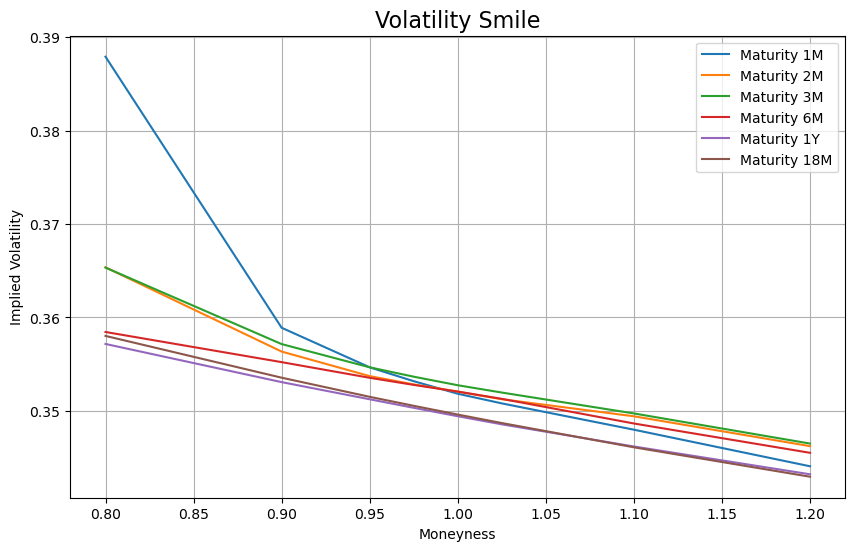

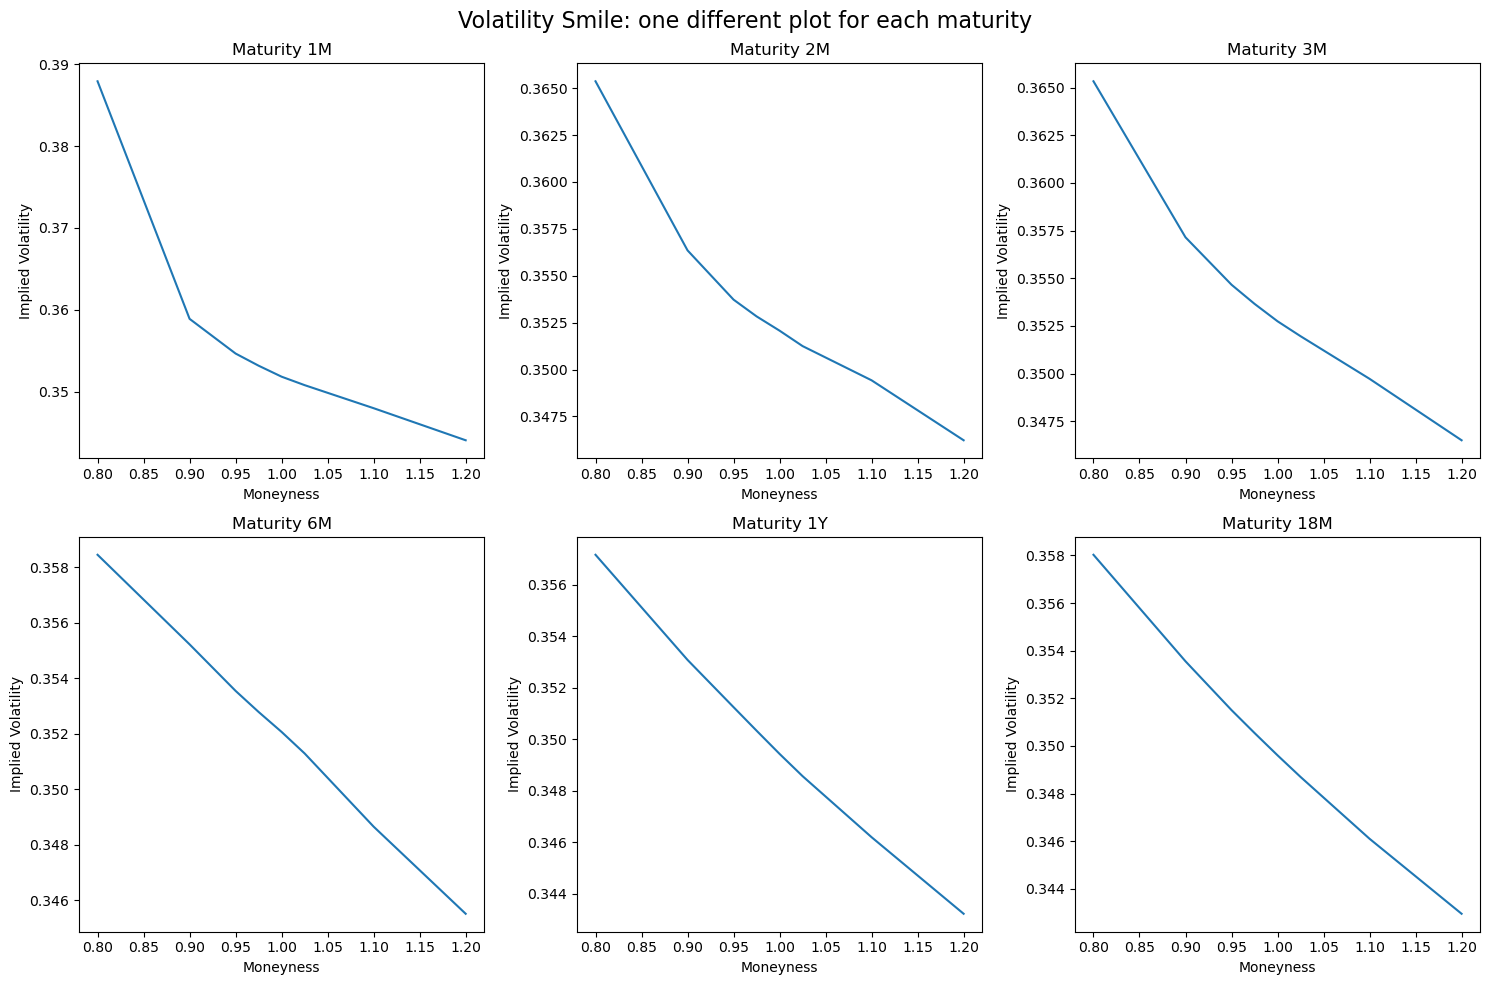

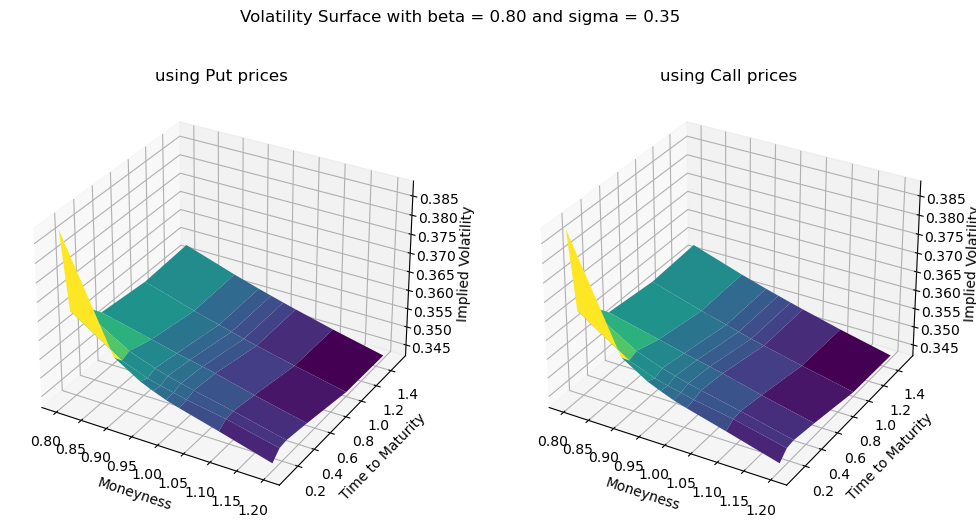



Implied volatilities with beta = 0.90 and sigma = 0.35


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.385236  0.357159  0.353819  0.352776   0.35186  0.351244  0.349614  0.347139
2M     0.3618  0.354598  0.352899  0.352455  0.352123  0.351727    0.3511   0.34939
3M   0.361686  0.355397  0.353848  0.353286  0.352812   0.35246   0.35143  0.349686
6M   0.354665  0.353467  0.352727   0.35243  0.352146   0.35179  0.350348   0.34872
1Y   0.353118  0.351135  0.350253    0.3498  0.349331  0.348919  0.347771  0.346304
18M  0.353925  0.351552  0.350469  0.349961  0.349479  0.348997  0.347631  0.345993




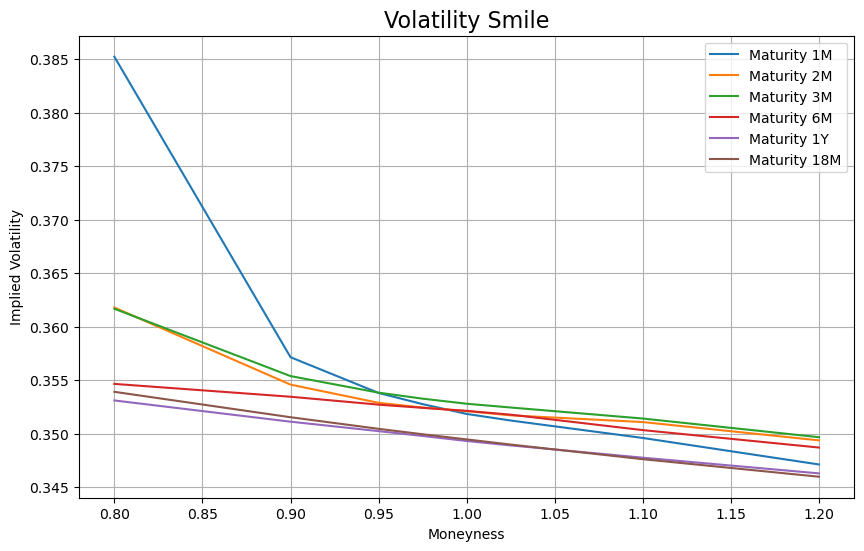

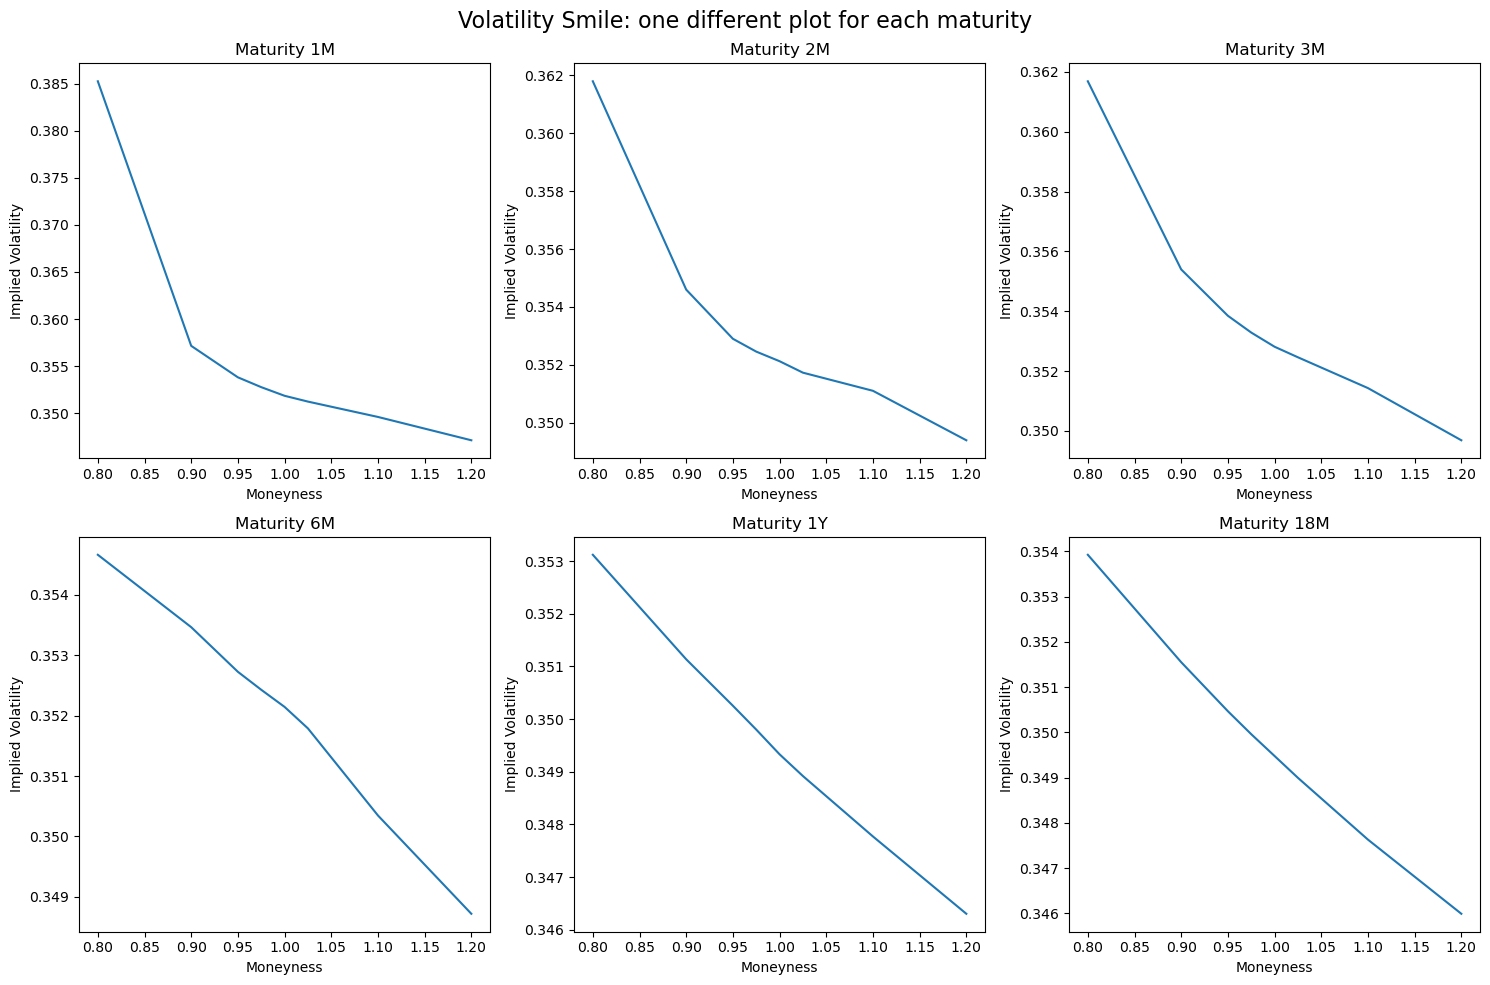

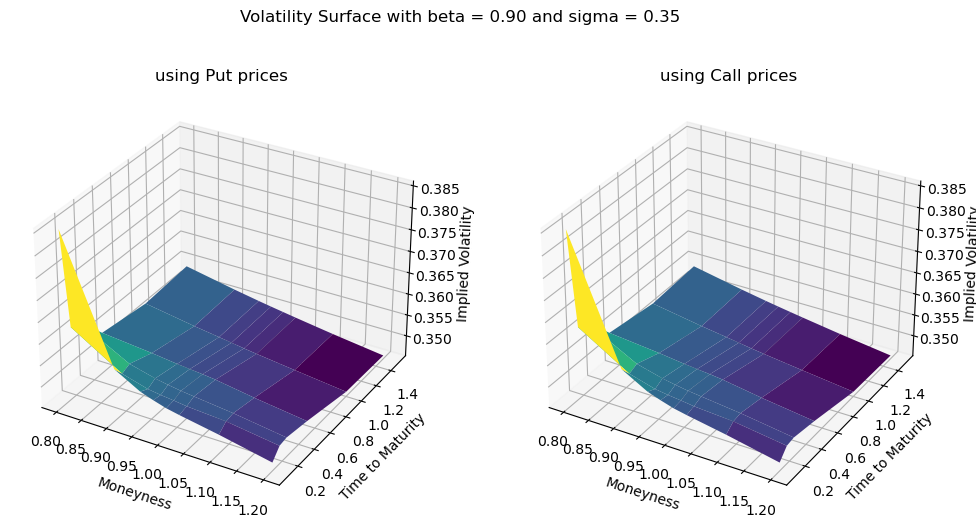



Implied volatilities with beta = 0.55 and sigma = 0.45


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.489888   0.46573  0.458509  0.455412  0.452386  0.449714  0.442464  0.432769
2M   0.478672  0.463683  0.457719  0.455145  0.452697  0.450238  0.443983   0.43528
3M   0.479548  0.464831  0.458926    0.4562    0.4536  0.451164  0.444293  0.435738
6M   0.474737  0.463093  0.457749   0.45527  0.452858   0.45047  0.443319  0.434301
1Y   0.472977  0.460718  0.455214  0.452565  0.449976  0.447446  0.440419  0.431806
18M  0.474214  0.461578  0.455861  0.453151  0.450509  0.447964    0.4407   0.43189




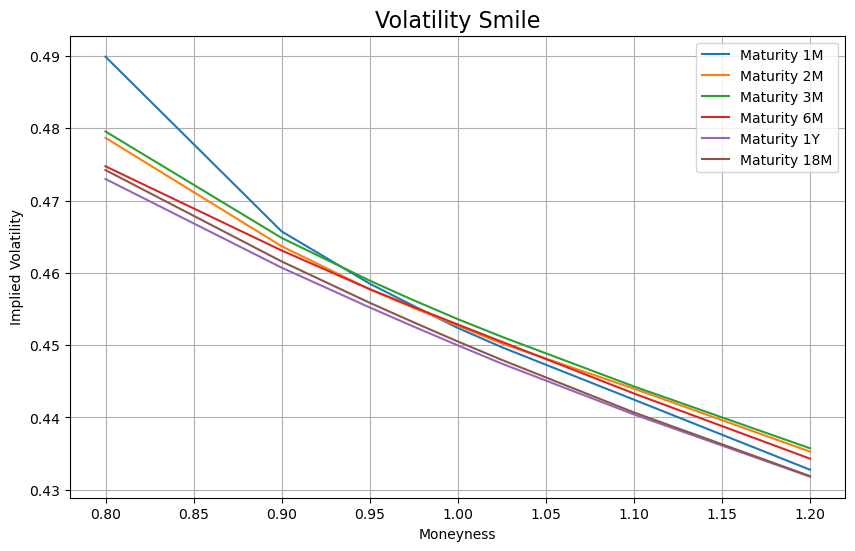

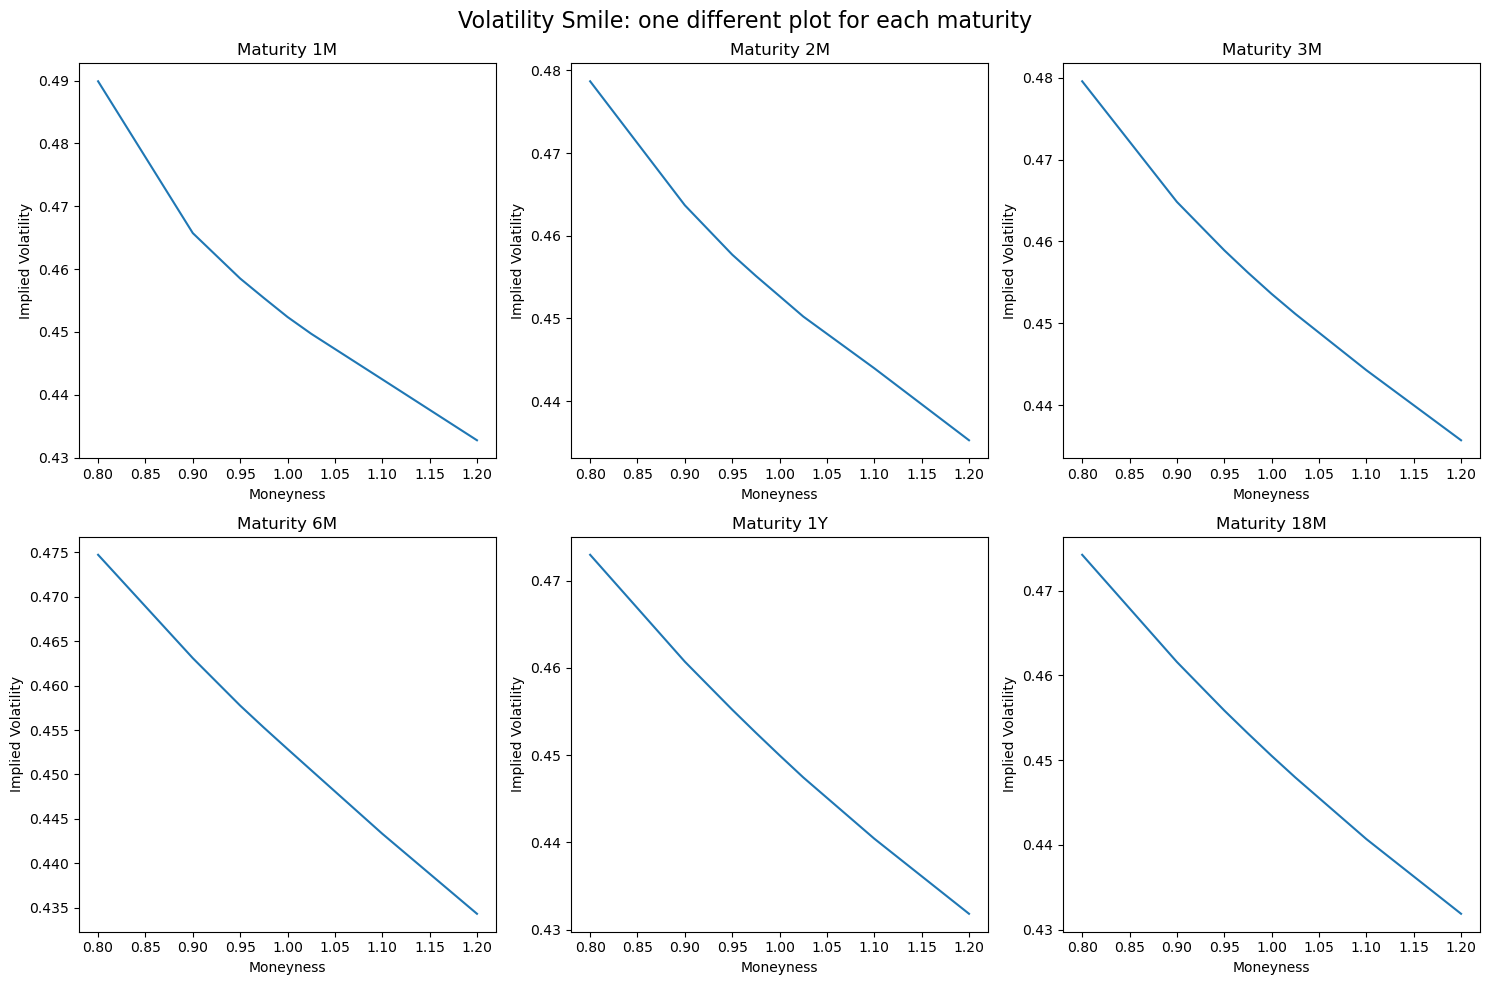

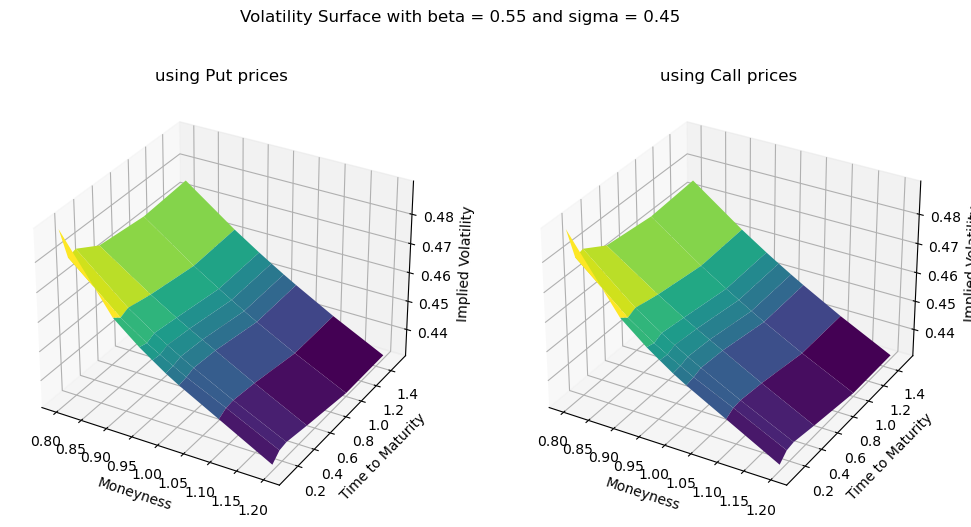



Implied volatilities with beta = 0.70 and sigma = 0.45


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.483154  0.462307  0.456866  0.454622  0.452416  0.450558  0.445567  0.438604
2M   0.471342   0.46022  0.456094  0.454388  0.452774  0.451126  0.447184  0.441262
3M   0.472128  0.461362  0.457292  0.455434  0.453682  0.452076  0.447521  0.441751
6M   0.467122  0.459556  0.456061  0.454465    0.4529  0.451301  0.446437  0.440266
1Y   0.464653  0.456629  0.452975  0.451224  0.449471  0.447819  0.443171  0.437398
18M  0.465603  0.457174  0.453363  0.451544  0.449795  0.448083  0.443206  0.437261




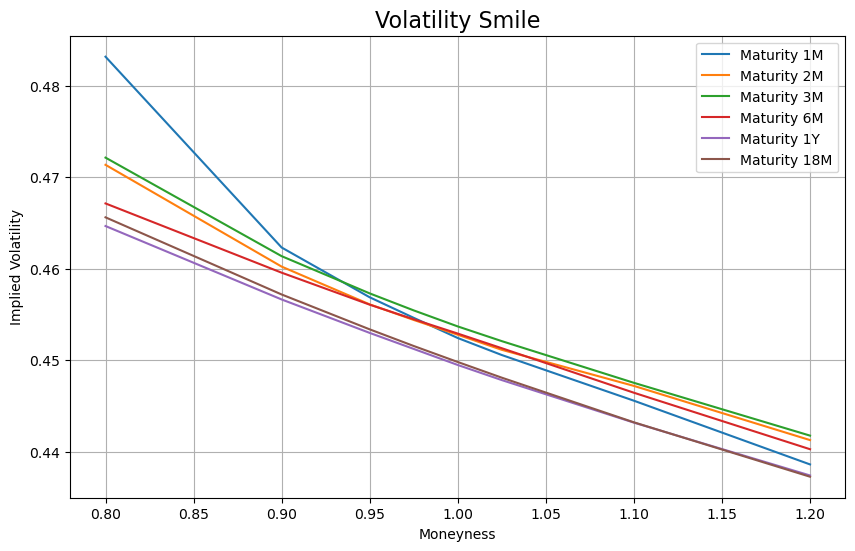

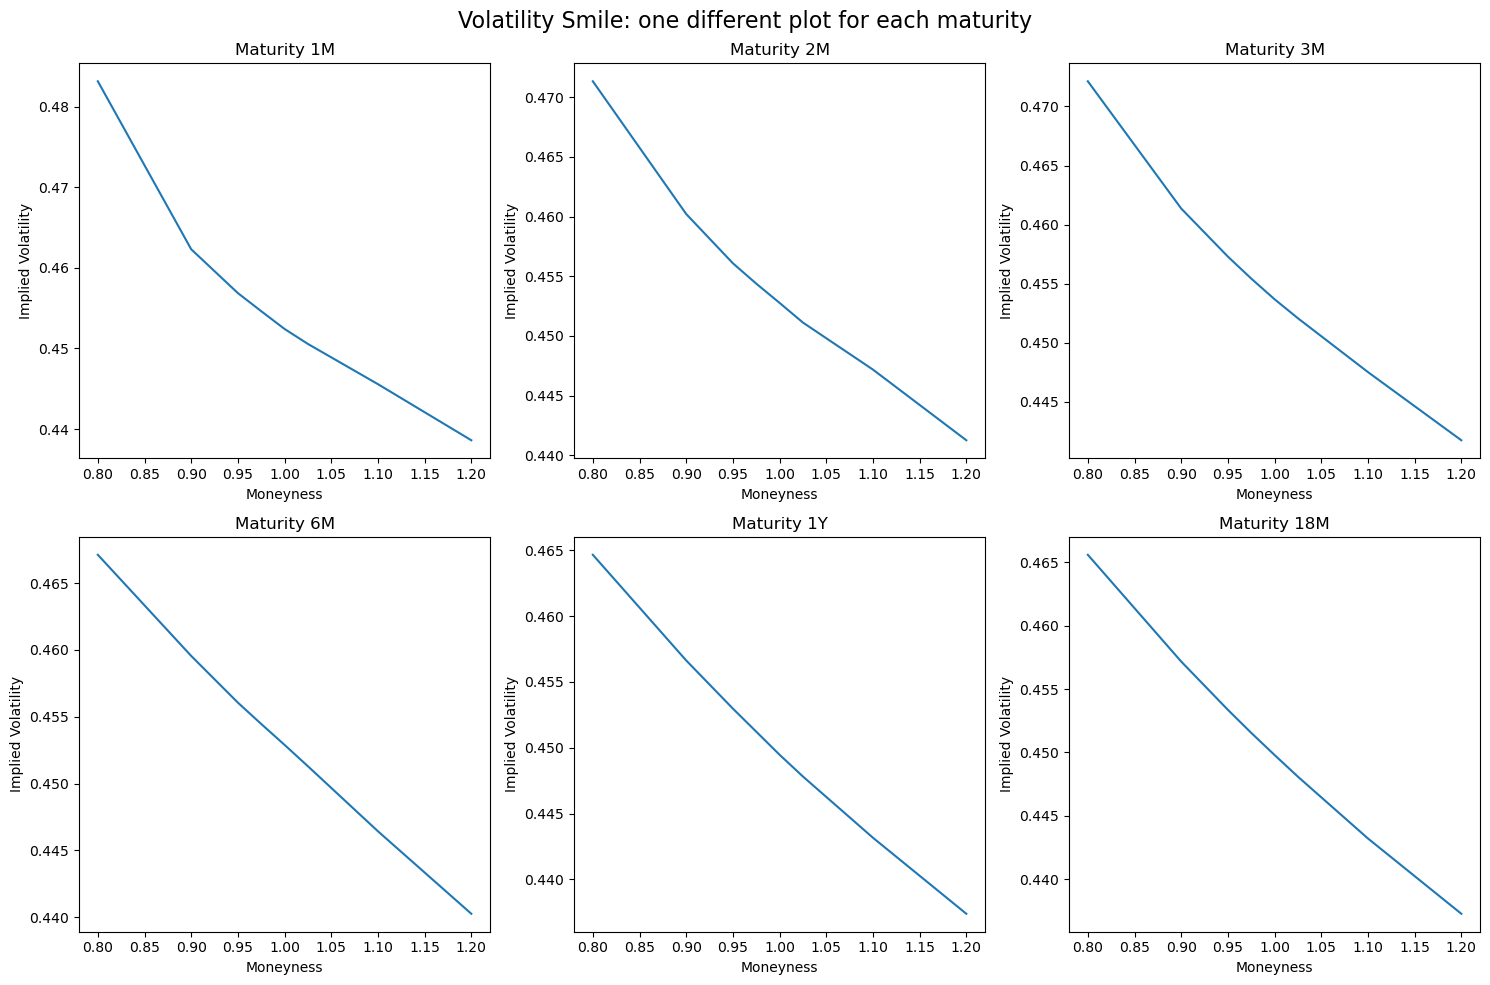

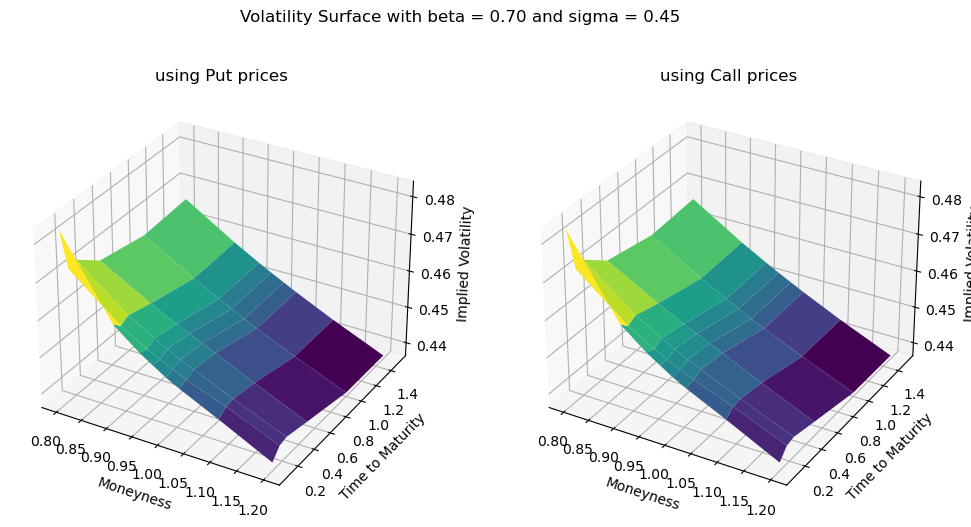



Implied volatilities with beta = 0.80 and sigma = 0.45


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.478752  0.460048  0.455787  0.454106  0.452449   0.45113  0.447654  0.442529
2M   0.466541  0.457949  0.455034  0.453906  0.452848  0.451741  0.449347  0.445302
3M   0.467278    0.4591  0.456237  0.454956  0.453769  0.452717  0.449711  0.445817
6M   0.462174  0.457272  0.455002   0.45399  0.452989  0.451925  0.448578  0.444329
1Y   0.459263  0.454008  0.451579  0.450399  0.449237  0.448158   0.44509  0.441224
18M  0.460074  0.454394  0.451836  0.450625  0.449441  0.448278  0.444997  0.440983




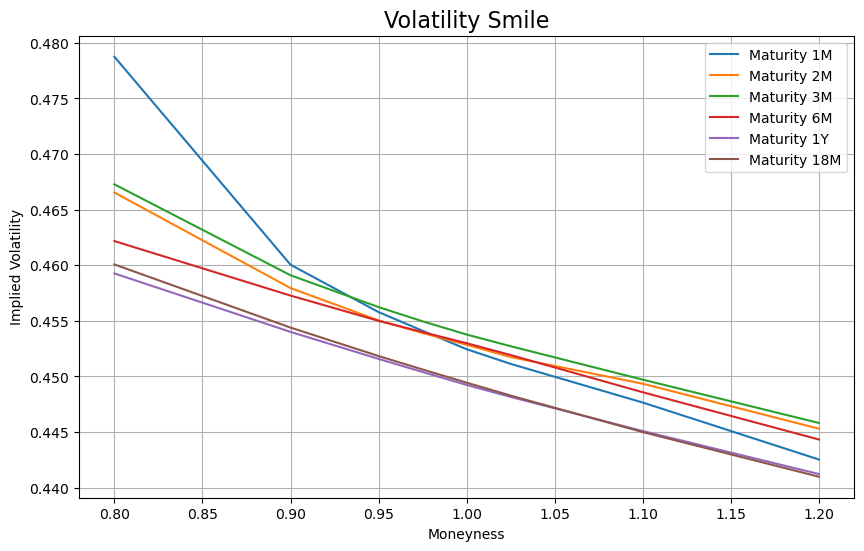

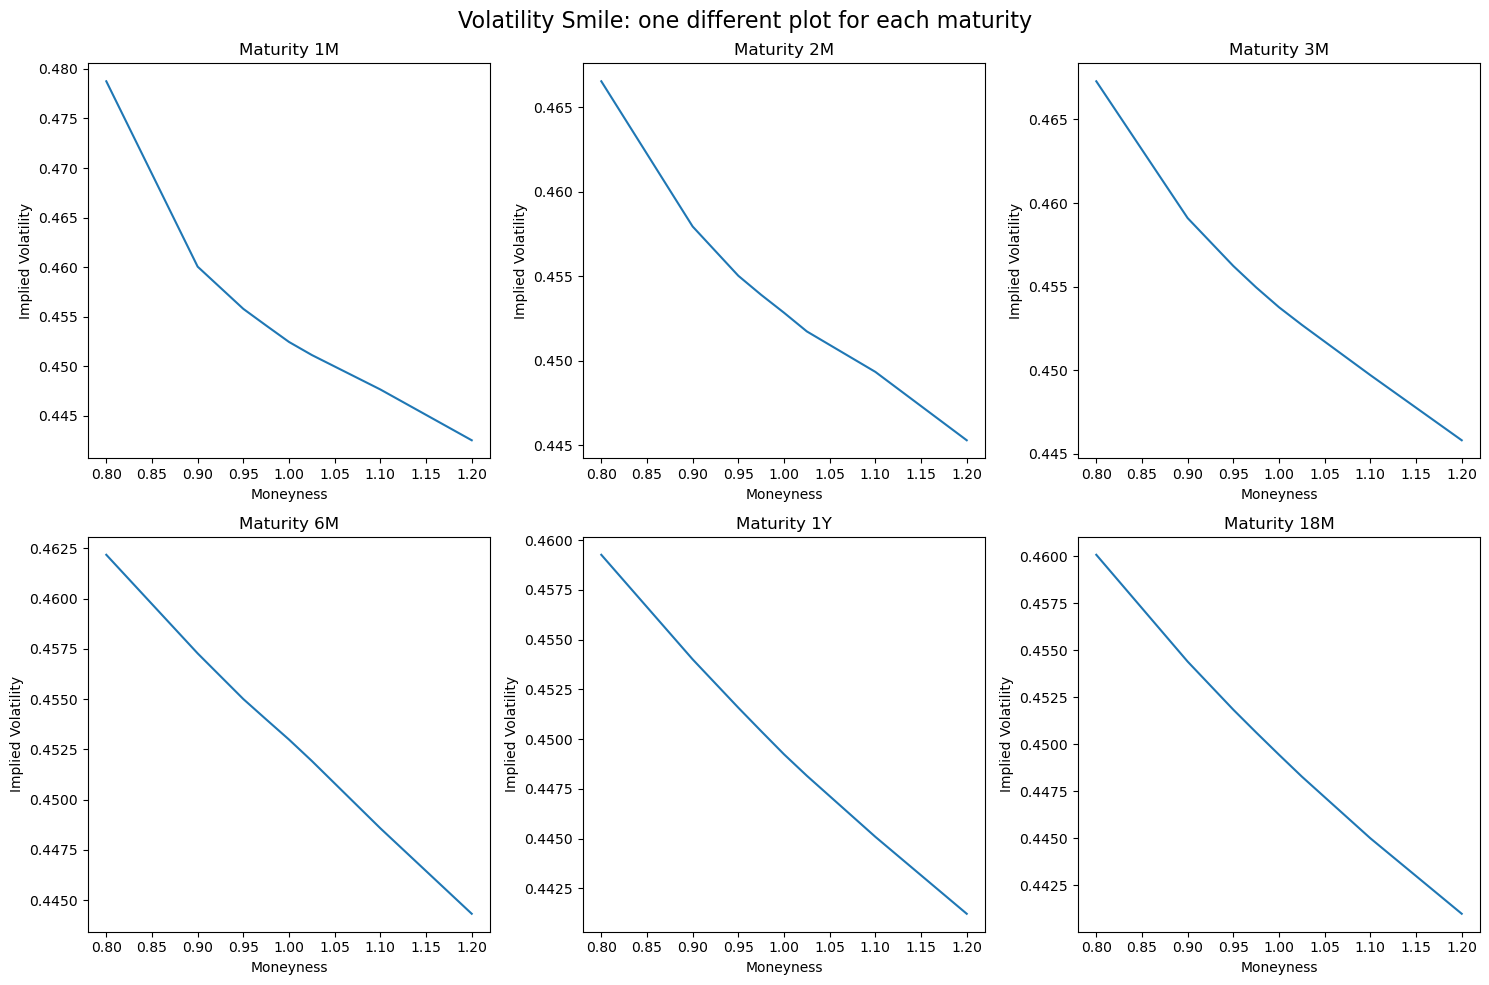

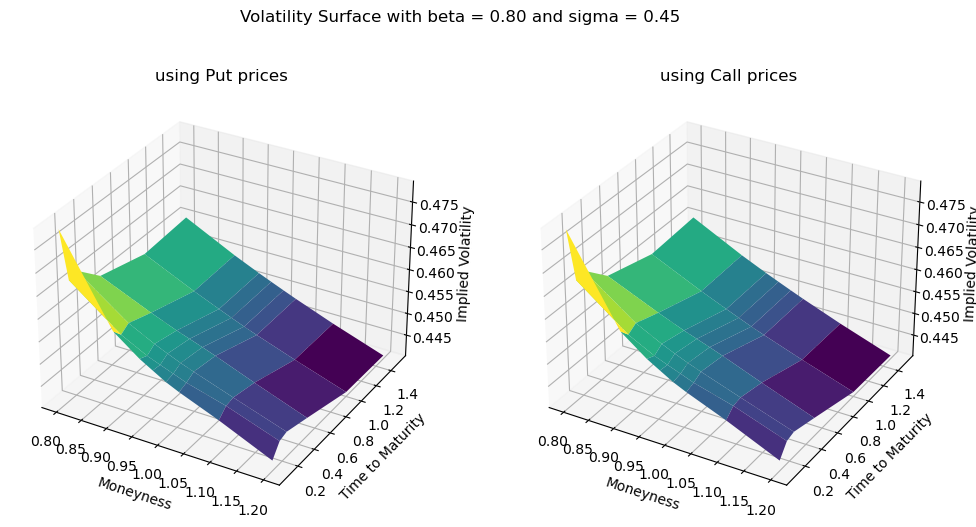



Implied volatilities with beta = 0.90 and sigma = 0.45


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.474411  0.457806  0.454719    0.4536  0.452492   0.45171  0.449756  0.446484
2M   0.461808  0.455706  0.453994  0.453442  0.452941  0.452377  0.451536  0.449383
3M   0.462504  0.456874  0.455209  0.454504  0.453887  0.453385  0.451936  0.449933
6M   0.457326  0.455049  0.454001  0.453568  0.453117  0.452592  0.450771  0.448467
1Y   0.453983  0.451451  0.450248  0.449639  0.449076  0.448557  0.447072  0.445128
18M  0.454691  0.451726  0.450416  0.449796  0.449178  0.448568  0.446875  0.444814




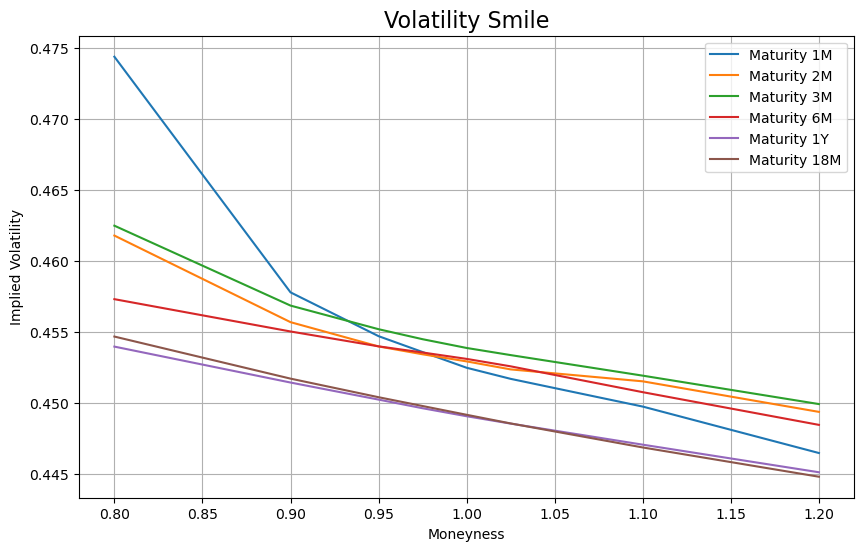

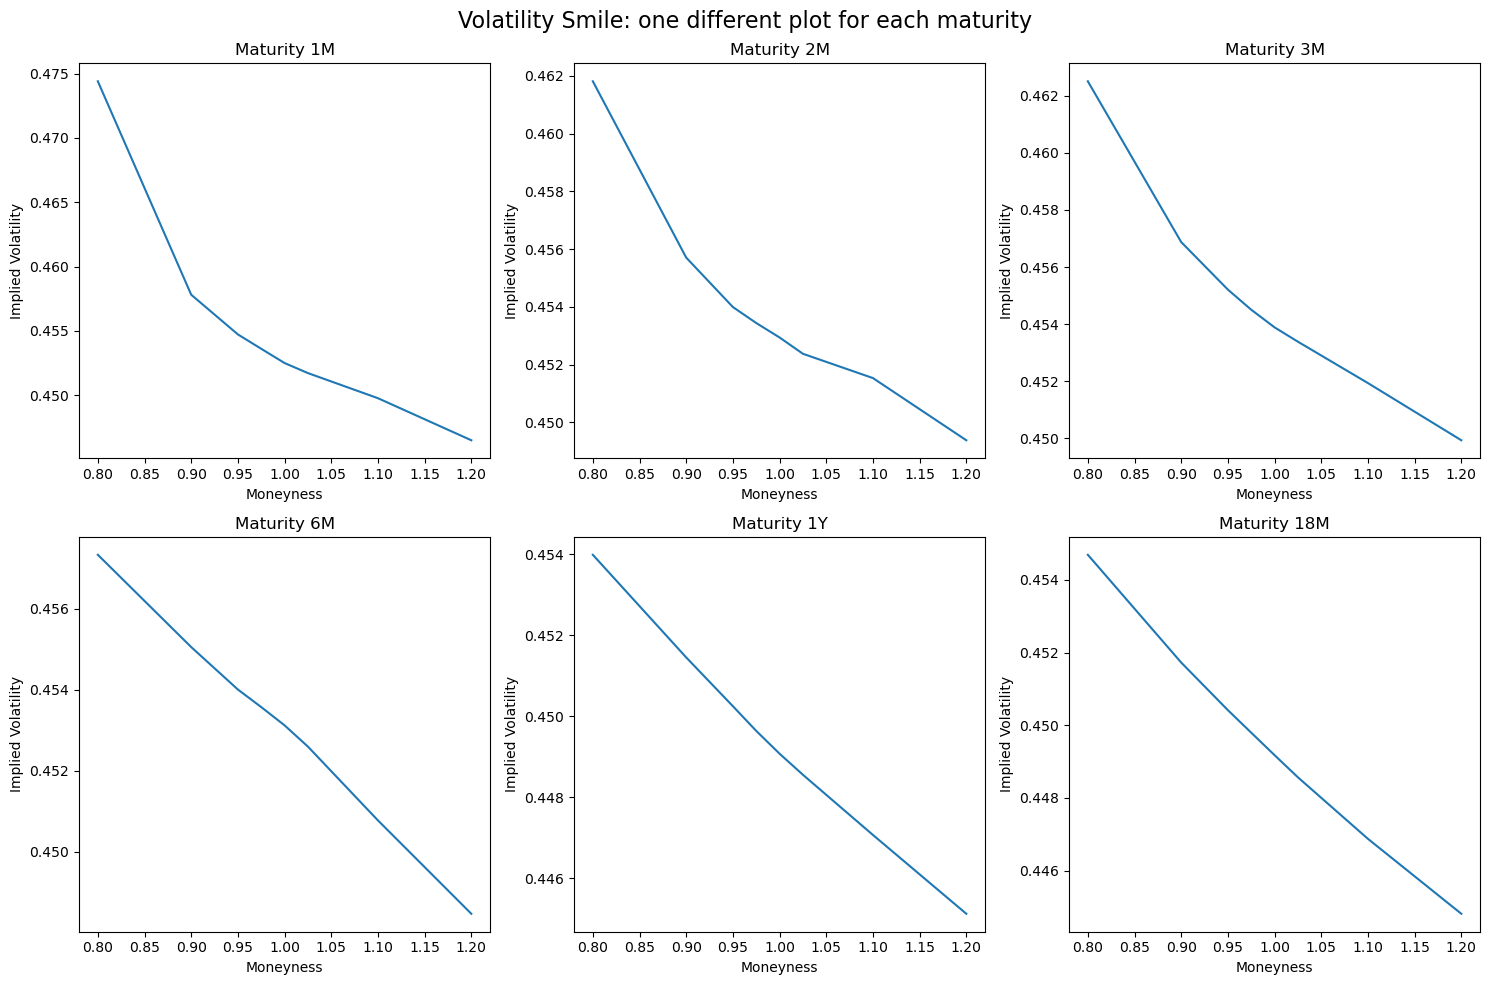

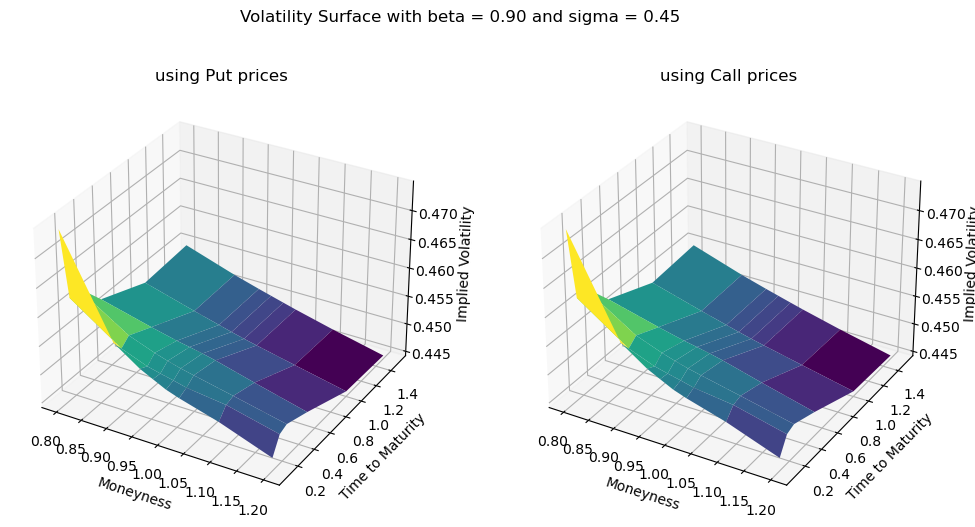



Implied volatilities with beta = 0.55 and sigma = 0.60


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.643402  0.620194  0.611323  0.607279  0.603355  0.599771      0.59  0.577628
2M   0.636859  0.618301  0.610753  0.607291  0.603957  0.600629  0.591844  0.580445
3M   0.638263  0.620114  0.612402  0.608771  0.605288  0.601979  0.592626  0.581314
6M   0.634493  0.618475  0.611299  0.607907  0.604593  0.601306  0.591772  0.579756
1Y    0.63128  0.615027  0.607618  0.604044   0.60056  0.597231  0.587818  0.576325
18M  0.632922  0.616148  0.608596  0.604992  0.601491  0.598096  0.588443  0.576721




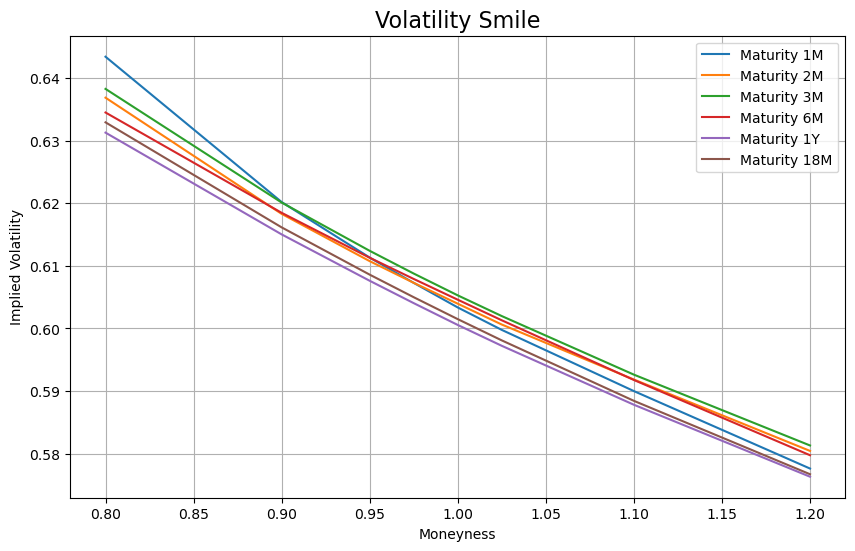

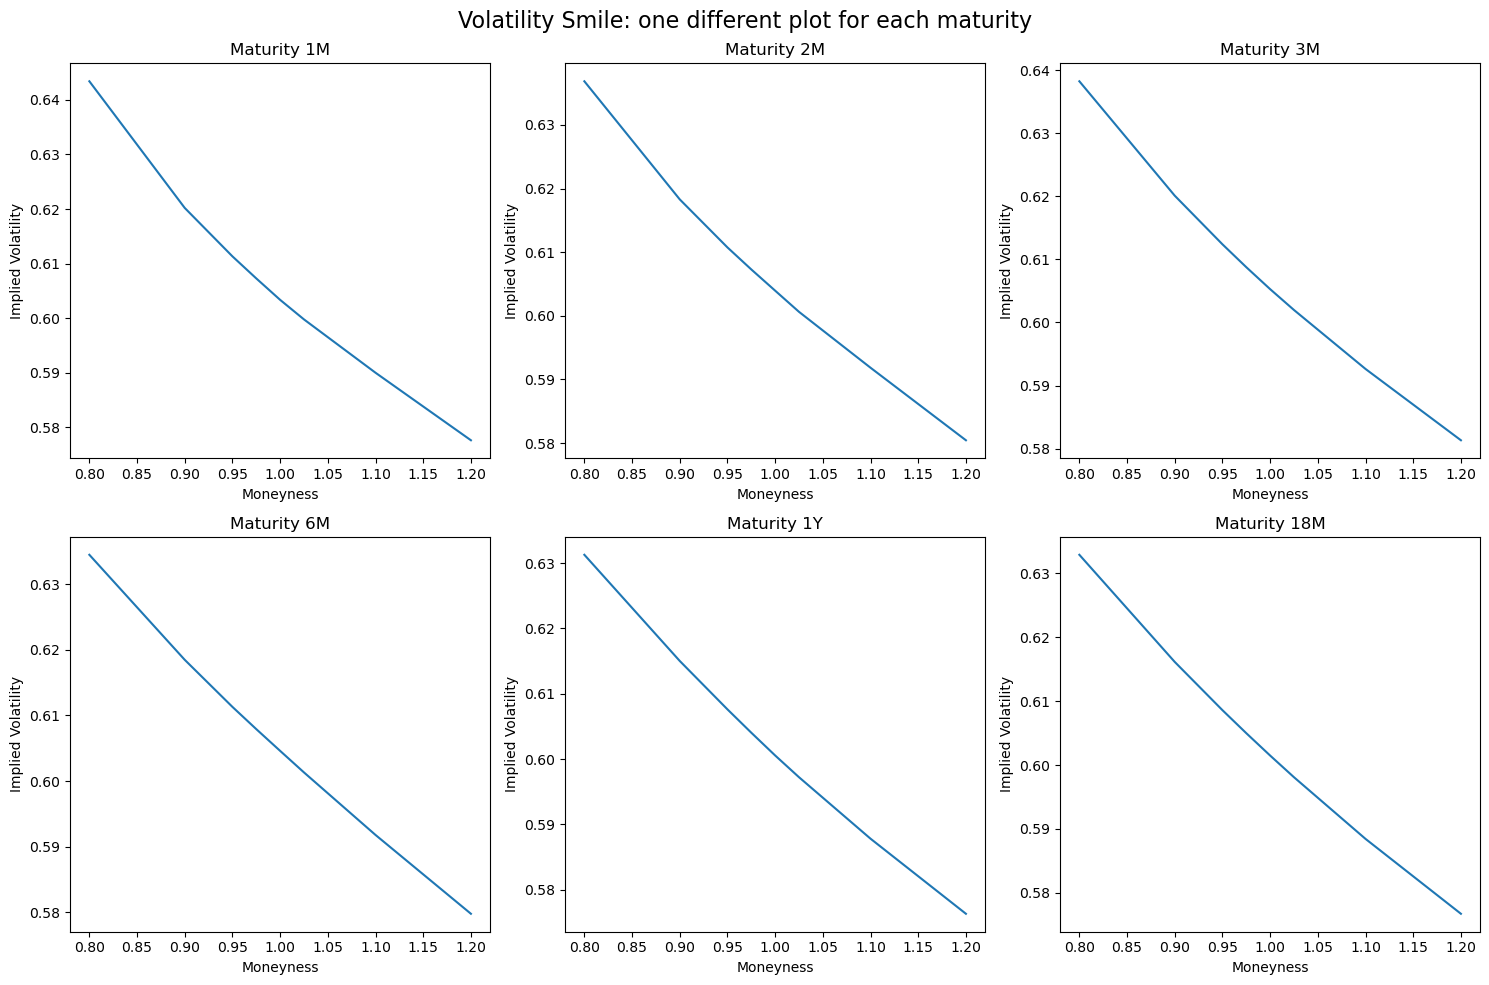

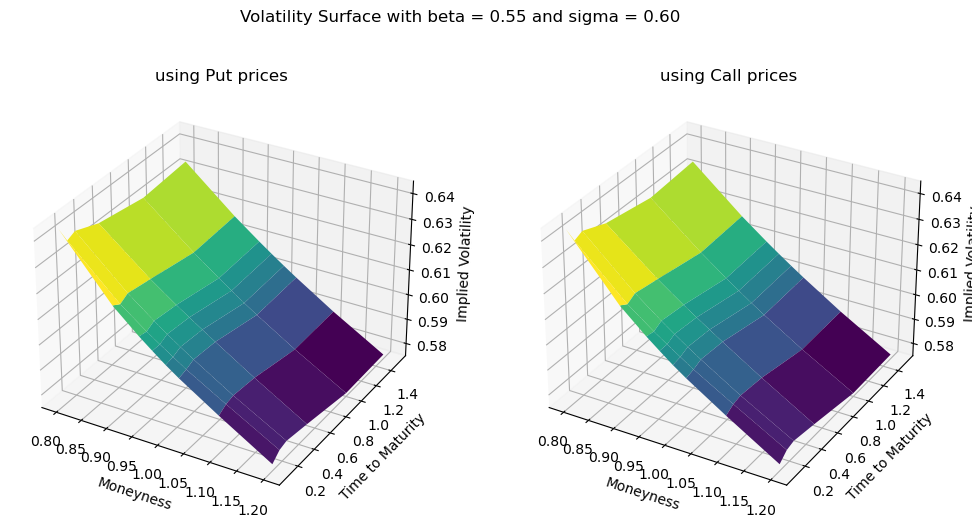



Implied volatilities with beta = 0.70 and sigma = 0.60


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.633778  0.615619   0.60914  0.606218  0.603406  0.600909  0.594152  0.585417
2M   0.626957  0.613709  0.608605  0.606305  0.604075  0.601828  0.596166  0.588419
3M   0.628258  0.615486  0.610199  0.607733  0.605403  0.603206  0.596936  0.589346
6M   0.624222  0.613667  0.608991  0.606756  0.604564  0.602356   0.59586  0.587654
1Y   0.619702  0.609069  0.604158  0.601777  0.599516  0.597337  0.591103  0.583403
18M  0.620705  0.609641  0.604644  0.602251  0.599916  0.597645  0.591223  0.583348




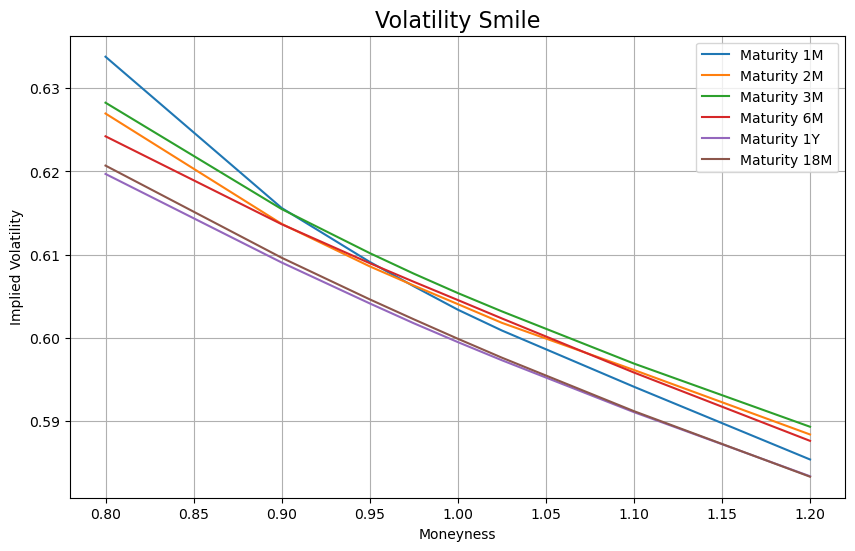

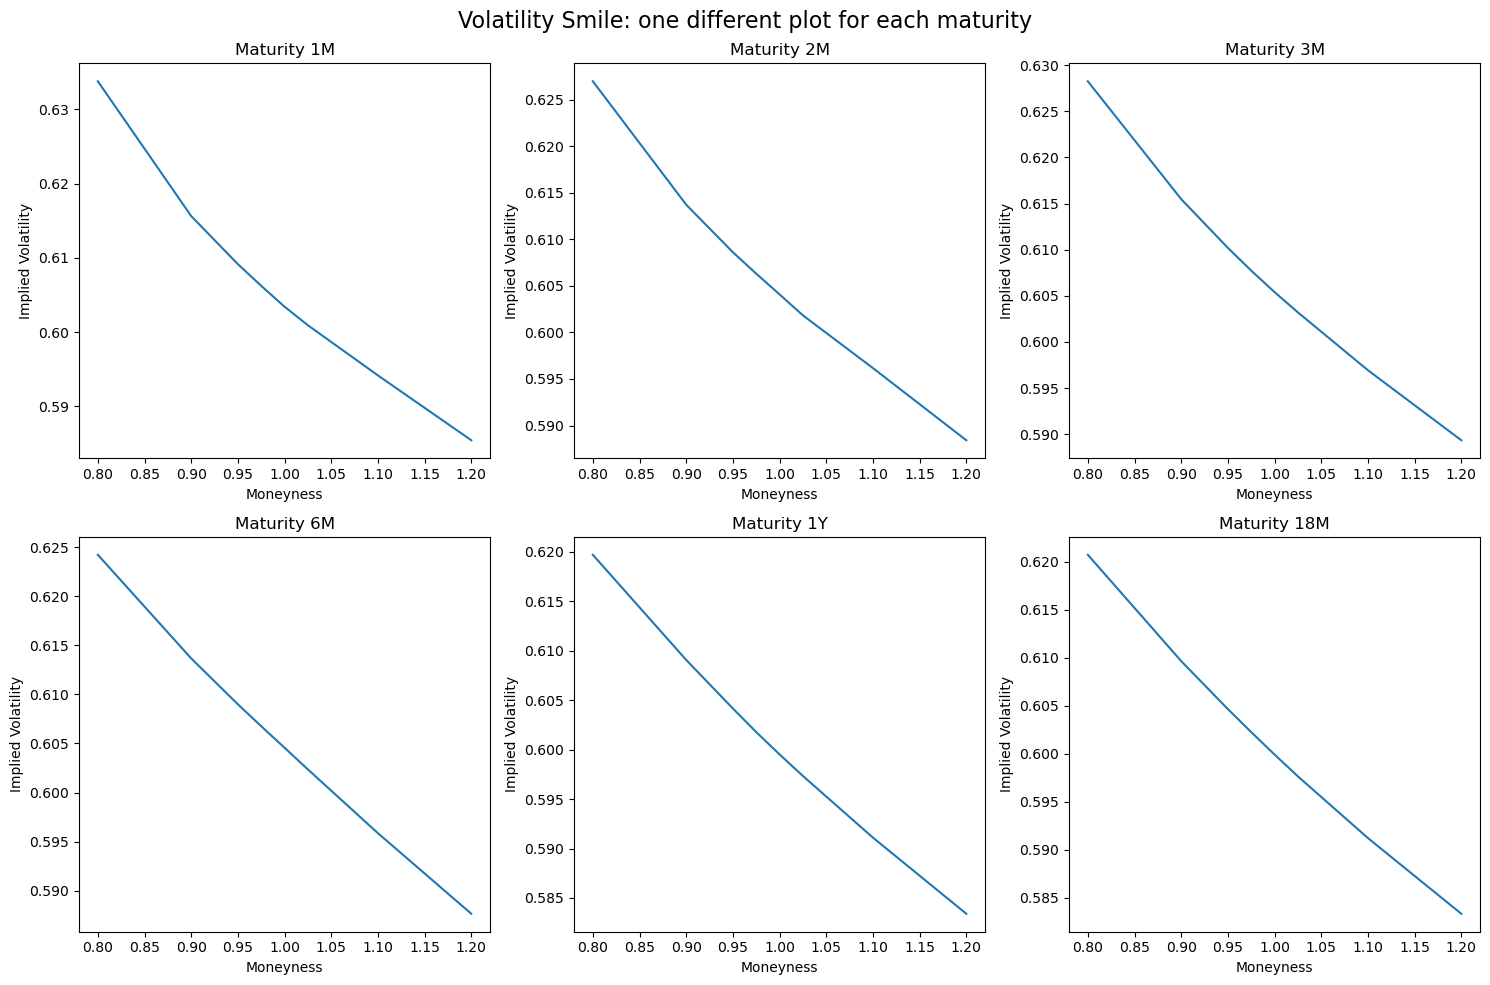

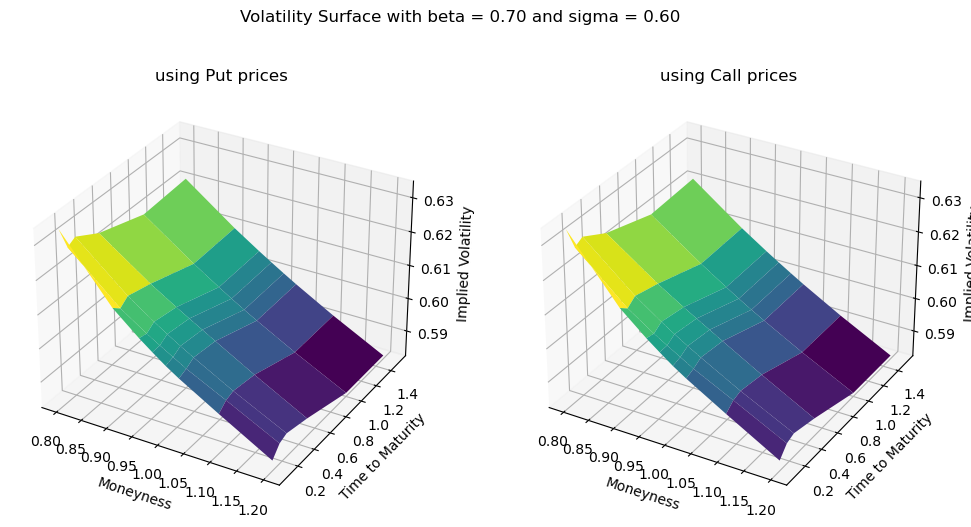



Implied volatilities with beta = 0.80 and sigma = 0.60


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.627465  0.612612  0.607717  0.605537   0.60347  0.601695  0.596954  0.590671
2M   0.620493  0.610719  0.607238   0.60571   0.60421  0.602679  0.599108  0.593821
3M   0.621755  0.612505  0.608824  0.607129  0.605557  0.604098  0.599895  0.594806
6M   0.617626  0.610647  0.607604   0.60614  0.604664  0.603192  0.598706   0.59308
1Y   0.612308  0.605343  0.602052   0.60051  0.599029  0.597592   0.59348  0.588313
18M  0.613004  0.605656  0.602321  0.600709  0.599146  0.597633  0.593327  0.588041




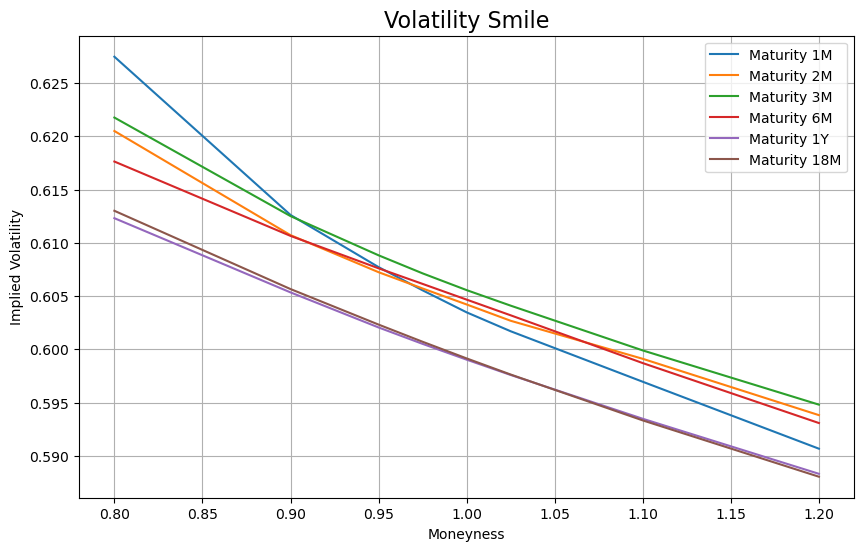

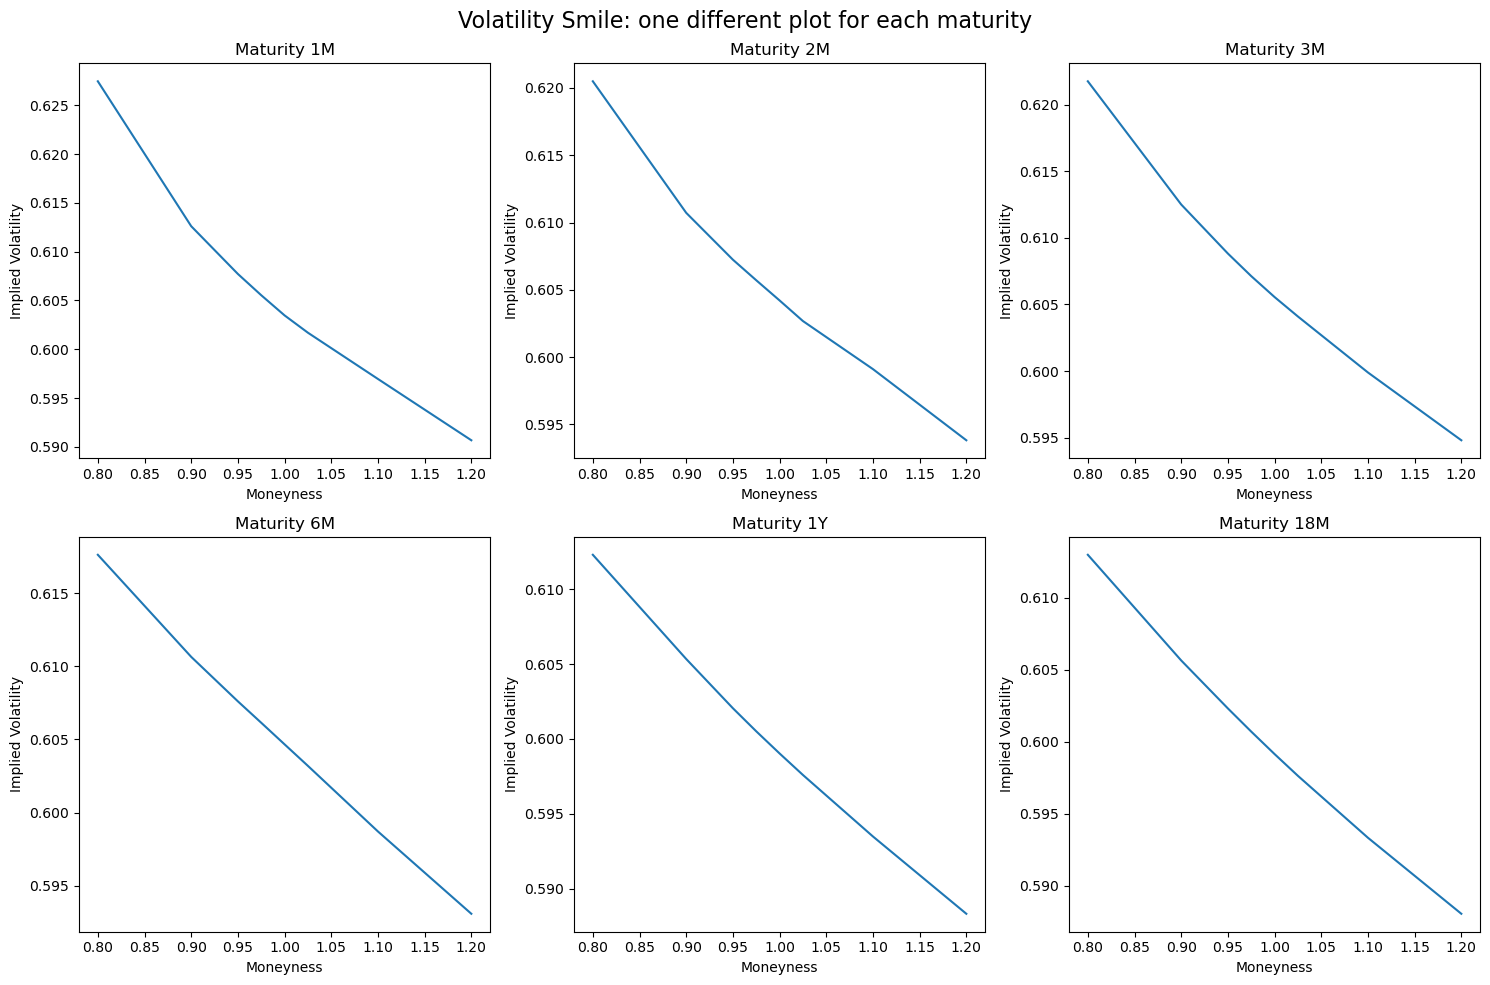

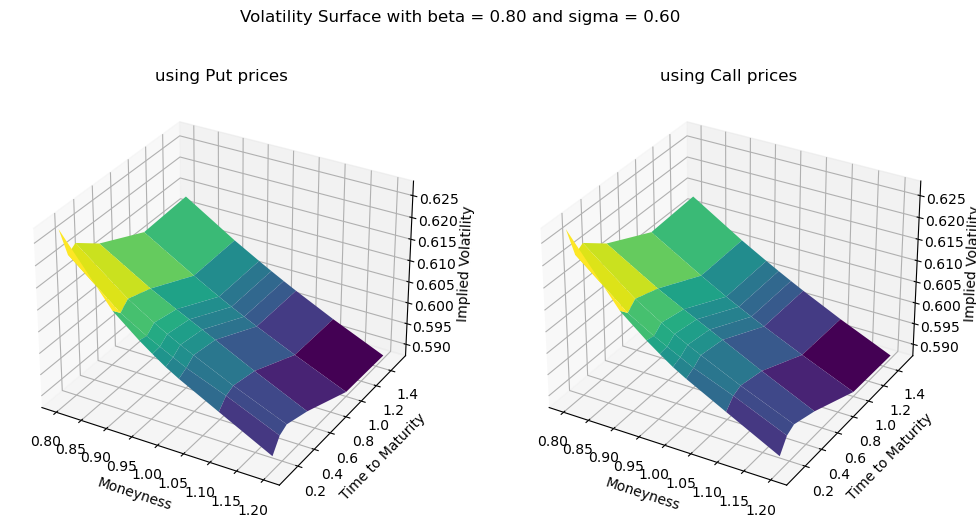



Implied volatilities with beta = 0.90 and sigma = 0.60


        0.800     0.900     0.950     0.975     1.000     1.025     1.100     1.200
1M   0.621232  0.609638   0.60632   0.60488  0.603555  0.602502  0.599785  0.595976
2M   0.614134  0.607788  0.605917  0.605159  0.604386  0.603574  0.602096  0.599297
3M   0.615383  0.609605  0.607519  0.606593  0.605771  0.605052  0.602923  0.600355
6M   0.611225  0.607769  0.606341  0.605644  0.604883  0.604132  0.601679  0.598642
1Y   0.605145  0.601768  0.600127  0.599388  0.598677  0.597985  0.595983  0.593377
18M  0.605599  0.601905  0.600196  0.599374  0.598584  0.597821  0.595637   0.59295




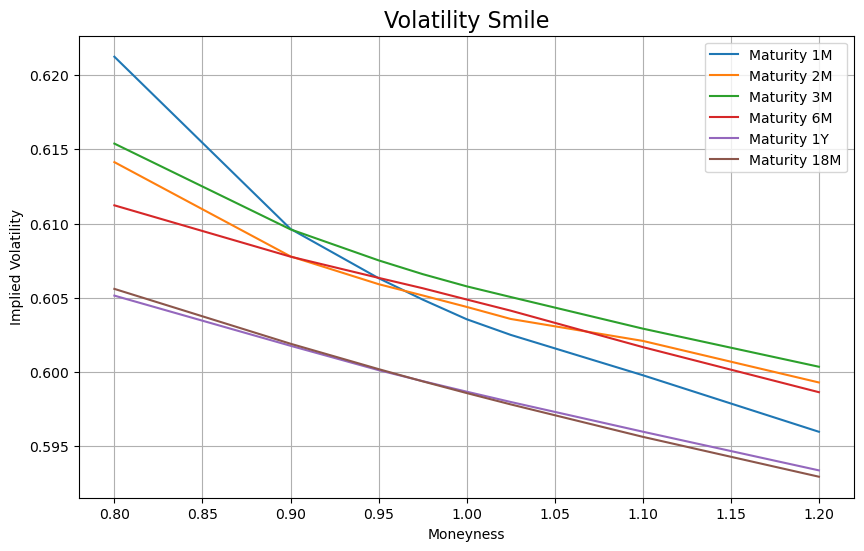

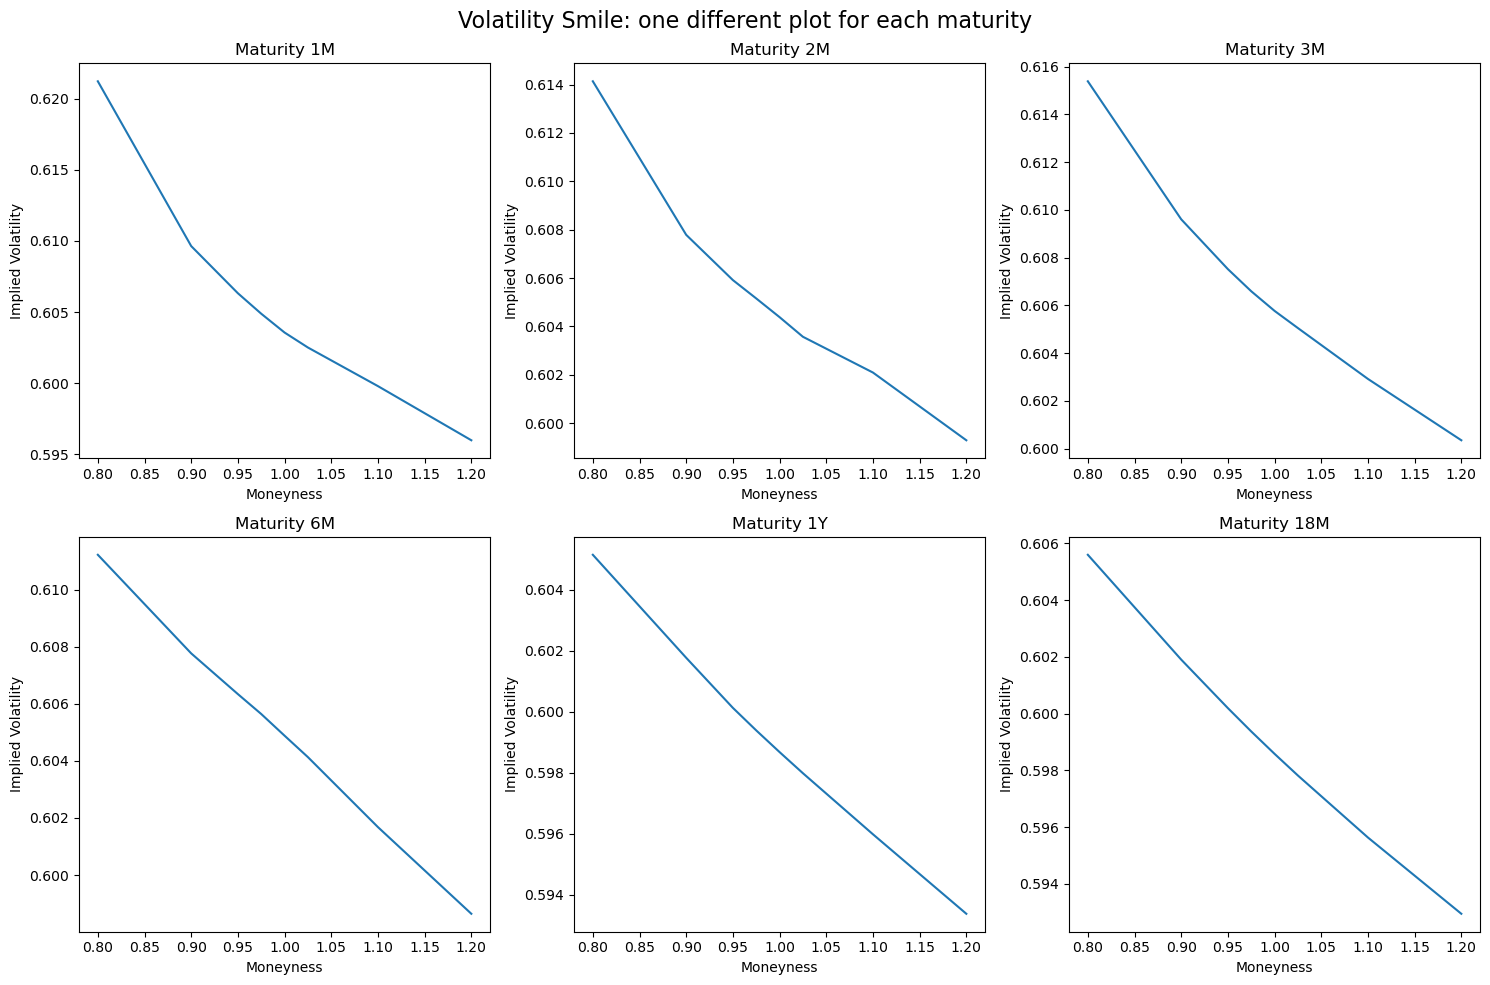

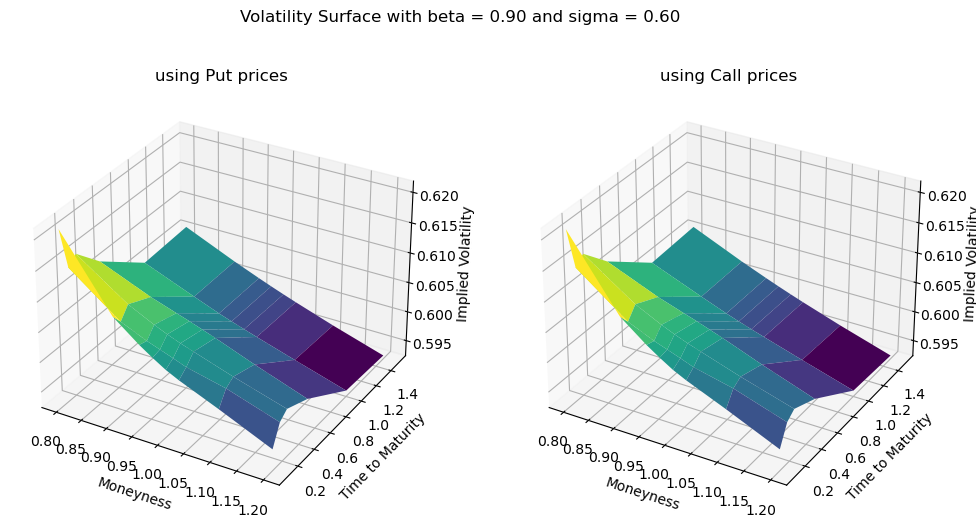

In [14]:
t1 = ['1M','2M','3M','6M','1Y','18M']
for s in sigma:
    for b in beta:
        S = S_t_met1(S_0, NS, Nt, s, b, dt, eps,normal)
        prices1 = np.zeros((6,len(Strikes)))
        vol1 = np.zeros((6,len(Strikes)))
        prices2 = np.zeros((6,len(Strikes)))
        vol2 = np.zeros((6,len(Strikes)))
        for i in range(len(Strikes)):
    
            prices1[:,i] = MC_CEV(S,Strikes[i],NS)[:,0]
            prices2[:,i] = MC_CEV(S,Strikes[i],NS)[:,1]
        
        for i in range(len(Strikes)):
            for j in range(6):
        
                vol1[j,i] = impVolFromFwPut(prices1[j,i], t[j], Strikes[i]) 
                vol2[j,i] = impVolFromFwCall(prices2[j,i], t[j], Strikes[i]) 
        
        

        dfVol = pd.DataFrame(index=t1, columns=Strikes)
        for i in range(len(t)):
            dfVol.iloc[i] = vol1[i].tolist()
            
        print('Implied volatilities with beta = {:.2f} and sigma = {:.2f}'.format(b,s))
        print('\n')
        print(dfVol.to_string())
        print('\n')
        
        
        
        # Volatility smile: plot all maturities in the same graph
        plt.figure(figsize=(10, 6))
        for i in range(len(t)):
            plt.plot(Strikes, vol1[i], label=f'Maturity {t1[i]}')
        plt.title('Volatility Smile', fontsize=16)
        plt.xlabel('Moneyness')
        plt.ylabel('Implied Volatility')
        plt.grid(True)
        plt.legend() 
        plt.show()

        # volatility smile: one different plot for each different maturity
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        for i, ax in enumerate(axs.flat):
            ax.plot(Strikes, vol1[i])
            ax.set_title(f'Maturity {t1[i]}')
            ax.set_xlabel('Moneyness')
            ax.set_ylabel('Implied Volatility')
            ax.grid(False) 
        fig.suptitle('Volatility Smile: one different plot for each maturity', fontsize=16)
        plt.tight_layout()
        plt.show()

        
        # volatility surfaces
        X, Y = np.meshgrid(Strikes,t)
        fig = plt.figure(figsize=(12, 6))
        
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.plot_surface(X, Y, vol1, cmap='viridis')
        ax1.set_xlabel('Moneyness')
        ax1.set_ylabel('Time to Maturity')
        ax1.set_zlabel('Implied Volatility')
        ax1.set_title('using Put prices')

        ax2 = fig.add_subplot(122, projection='3d')
        ax2.plot_surface(X, Y, vol2, cmap='viridis')
        ax2.set_xlabel('Moneyness')
        ax2.set_ylabel('Time to Maturity')
        ax2.set_zlabel('Implied Volatility')
        ax2.set_title('using Call prices')
        
        fig.suptitle('Volatility Surface with beta = {:.2f} and sigma = {:.2f}'.format(b,s))
        plt.show()
        print('\n')